In [1]:
import os
import obspy
from obspy import UTCDateTime
import pandas as pd
from pandas import read_csv
from obspy import read_inventory
import glob
import pygmt
from pyproj import Geod

In [2]:
INVE='/home/jovyan/shared/users/spina/Norcia/INVENTORY/*.xml'

ii  = glob.glob(INVE)
inventory=obspy.Inventory()

for e in ii:
    inventory+=read_inventory(e)


### Station and Network list for figure legend

In [3]:
stalist=set()
netset=set()
# for net in inventory.select(channel="*Z"):
for net in inventory.select(channel="*Z"):
    for sta in net:
        stalist.add(sta.code)
        netset.add(net.code)

In [4]:
netlist=[]
for i,sta in enumerate(stalist):
    netlist.append(inventory.select(station=sta)[0].code)

### Create list for legend only

In [5]:
legenda = ['T1201','ATVA', 'AQU', 'AM05']
staleg_lon=[]
staleg_lat=[]
for sta in legenda:
    idseed = inventory.select(station=sta).get_contents()['channels'][0]
    staleg_lat.append(inventory.get_coordinates(idseed)['latitude'])
    staleg_lon.append(inventory.get_coordinates(idseed)['longitude'])


/home/jovyan/envs/gmt/lib/python3.11/site-packages/obspy/core/inventory/inventory.py:482: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


### Create list to plot stations

In [6]:
sta_lon=[]
sta_lat=[]
for sta in stalist:
    idseed = inventory.select(station=sta).get_contents()['channels'][0]
    sta_lat.append(inventory.get_coordinates(idseed)['latitude'])
    sta_lon.append(inventory.get_coordinates(idseed)['longitude'])


## Read Faults data

In [7]:
import pandas as pd

# Supponiamo che il file si chiami 'data.txt'
# Il parametro sep='\t' indica che i campi sono separati da tabulazioni
df_fault = pd.read_csv('Villani-etal_2017.xyz', sep='\t', skiprows=1, names=['Lat', 'Lon', 'Depth','fix'])

# Visualizza le prime righe del DataFrame per verificare il contenuto
print(df_fault.head())


         Lat        Lon  Depth   fix
0  42.892671  13.169741 -0.963  0.05
1  42.892671  13.169741 -0.963  0.05
2  42.892671  13.169741 -0.963  0.05
3  42.892671  13.169741 -0.963  0.05
4  42.893348  13.169394 -1.004  0.05


## Read ingv original catalog

In [8]:
ingv_orig=read_csv('./QuakeML_Norcia_2016_20161020-1130_ingv.text',sep='|')
ingv_orig['Time']=ingv_orig['Time'].apply(UTCDateTime)

In [9]:
ingv_orig

#EventID                         Time  Latitude  Longitude  Depth/Km  \
0       8587961  2016-10-20T00:16:44.250000Z   42.9143    13.2377       6.1   
1       8588051  2016-10-20T00:38:34.120000Z   42.8187    13.2237       7.7   
2       8588151  2016-10-20T00:54:51.020000Z   42.7350    13.1887       9.2   
3       8588201  2016-10-20T00:56:50.650000Z   42.7572    13.1338      10.1   
4       8588231  2016-10-20T00:58:04.950000Z   42.7392    13.1920      10.2   
...         ...                          ...       ...        ...       ...   
13983  10830541  2016-11-30T23:13:43.860000Z   42.8597    13.1555       8.9   
13984  10830821  2016-11-30T23:19:50.500000Z   42.9205    13.0352      10.9   
13985  10831131  2016-11-30T23:26:45.670000Z   42.8673    13.2390      10.7   
13986  10831201  2016-11-30T23:28:01.780000Z   42.8427    13.0363      10.1   
13987  10831931  2016-11-30T23:49:04.880000Z   42.7507    13.2302      15.8   

              Author  Catalog  Contributor  ContributorID MagType  Magnitude  \
0        SURVEY-INGV      NaN          NaN            NaN      ML        1.5   
1        SURVEY-INGV      NaN          NaN            NaN      Md        1.2   
2      BULLETIN-INGV      NaN          NaN            NaN      ML        2.9   
3      BULLETIN-INGV      NaN          NaN            NaN      ML        2.4   
4        SURVEY-INGV      NaN          NaN            NaN      ML        1.8   
...              ...      ...          ...            ...     ...        ...   
13983    SURVEY-INGV      NaN          NaN            NaN      ML        1.7   
13984    SURVEY-INGV      NaN          NaN            NaN      ML        1.9   
13985    SURVEY-INGV      NaN          NaN            NaN      ML        1.3   
13986    SURVEY-INGV      NaN          NaN            NaN      ML        1.7   
13987    SURVEY-INGV      NaN          NaN            NaN      ML        1.6   

      MagAuthor                      EventLocationName   EventType  
0            --  7 km E Castelsantangelo sul Nera (MC)  earthquake  
1            --        8 km NW Arquata del Tronto (AP)  earthquake  
2            --                  7 km NW Accumoli (RI)  earthquake  
3            --                    5 km SE Norcia (PG)  earthquake  
4            --                  7 km NW Accumoli (RI)  earthquake  
...         ...                                    ...         ...  
13983        --  4 km S Castelsantangelo sul Nera (MC)  earthquake  
13984        --                      5 km N Preci (PG)  earthquake  
13985        --  8 km E Castelsantangelo sul Nera (MC)  earthquake  
13986        --                      4 km S Preci (PG)  earthquake  
13987        --         6 km W Arquata del Tronto (AP)  earthquake  

[13988 rows x 14 columns]

## Read INGV and PhaseNet NLLoc-SC relocation

In [11]:
ingv_nll=read_csv("/home/jovyan/shared/users/spina/Norcia/ANTHONY/20240704A_NEW_INGV_coherence_Norcia_2016.sum_ALL.grid0.loc.csv", sep=',', skipinitialspace=True)
pn_inst= pd.read_csv("/home/jovyan/shared/users/spina/Norcia/ANTHONY/20240704C_NEW_PN_INSTANCE28_coherence_Norcia_2016.sum_ALL.grid0.loc.csv", sep=',', skipinitialspace=True)
pn_orig= pd.read_csv("/home/jovyan/shared/users/spina/Norcia/ANTHONY/20240704B_NEW_PN_ORIG28_coherence_Norcia_2016.sum_ALL.grid0.loc.csv", sep=',', skipinitialspace=True)

## Merge ingv_nll, pn_inst, pn_orig to ingv_orig to assign magnitude

In [12]:
ingv_nll = pd.merge(ingv_nll, ingv_orig[['#EventID', 'Magnitude']], left_on='publicId', right_on='#EventID', how='left')
pn_inst = pd.merge(pn_inst, ingv_orig[['#EventID', 'Magnitude']], left_on='publicId', right_on='#EventID', how='left')
pn_orig = pd.merge(pn_orig, ingv_orig[['#EventID', 'Magnitude']], left_on='publicId', right_on='#EventID', how='left')

### Convert date-time string to UTCDateTime

In [13]:
ingv_nll['date-time'] = ingv_nll['date-time'].apply(lambda x: UTCDateTime(x))
pn_inst['date-time'] = pn_inst['date-time'].apply(lambda x: UTCDateTime(x))
pn_orig['date-time'] = pn_orig['date-time'].apply(lambda x: UTCDateTime(x))


# Figure 4

In [14]:
def plot_epicenter_time(df,pan_lab,nome):


    # Define the center coordinates
    center = (13.1, 42.825)

    # Define a smaller region around the center with a higher resolution
    lat_range = 0.15  # Latitude range to add/subtract from the center
    lon_range = 0.25  # Longitude range to add/subtract from the center

    # Calculate the region around the center
    region = [
        center[0] - lon_range,  # Western longitude
        center[0] + lon_range,  # Eastern longitude
        center[1] - lat_range,  # Southern latitude
        center[1] + lat_range   # Northern latitude
    ]


    font = "18p,Helvetica"
    font2 = "18p,Helvetica-Bold"
    
    ## Define colors
    color_1='#E62B2B'
    color_2="#0099CC"
    color_3='#393b79'

    
    transp=50
    wid=[-3,3]
    dim='p0.1c'

    main=df.loc[df['Magnitude']>= 5.5].sort_values(by=['Magnitude'],ascending=True)
    first_event_time = main['date-time'].iloc[0]
    second_event_time = main['date-time'].iloc[1]
    
    # Add 'date-time' column in sec
    df['time_seconds'] =df['date-time'].apply(lambda x: x.timestamp)

    
    # Create a new 'color' column 
    df['color'] = df['date-time'].apply(lambda x: 
                                          color_1 if x <= first_event_time else
                                          color_2 if first_event_time < x <= second_event_time else
                                          color_3)

    
    # Create the figure
    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain",FONT_ANNOT_PRIMARY="16p", FONT_ANNOT_SECONDARY="16p", FONT_LABEL="18p")
    with pygmt.config(MAP_FRAME_TYPE="plain"):
        if pan_lab == "(a)":
            fig.basemap(region=region, projection="M20c", frame=["rSWt", "xa0.1", "ya0.1"])
        else:
            fig.basemap(region=region, projection="M20c", frame=["rSwt", "xa0.1", "ya0.1"])

    ti=UTCDateTime("2016-10-20T0:0:0")
    time1 = UTCDateTime("2016-10-26T19:18:06.574000Z")
    time2 = UTCDateTime("2016-10-30T06:40:18.130000Z")
    tf=UTCDateTime("2016-12-1T0:0:0")

    cpt_content = f"""
    # COLOR_MODEL = RGB
    {ti} {color_1} {time1} {color_1}
    {time1} {color_2} {time2} {color_2}
    {time2} {color_3} {tf} {color_3}
    B   85 26 139
    F 255 69 0
    N 255   0   0
    """

    with open("time_palette.cpt", "w") as f:
        f.write(cpt_content)

    pygmt.makecpt(cmap="time_palette.cpt")
    
    # Plot the coastlines with high resolution
    fig.coast(region=region, shorelines=True, resolution='h')  # 'h' for high resolution shorelines
    fig.coast(rivers="1/0.5p,blue",land="white", water="skyblue")  # Rivers

    # Define a color mapping for the network codes (customize as needed)
    color_map = {
        'IV': 'orange',
        '8P': 'green',
        'MN': 'blue',
        'XO': 'magenta'
    }

    for i, net in enumerate(netset):
        fig.plot(
            x=[staleg_lon[i]], 
            y=[staleg_lat[i]], 
            style="i0.3c",  # Triangular marker
            fill=color_map[net],  # Color based on netlist
            pen="1p,black",  # Outline the triangle with a black pen
            label=f"Network {net}"  # Label each station (optional)
        )

    # Plot stations with triangles, colored based on the netlist code
    for i, net in enumerate(netlist):
        fig.plot(
            x=[sta_lon[i]], 
            y=[sta_lat[i]], 
            style="i0.3c",  # Triangular marker
            fill=color_map[net],  # Color based on netlist
            pen="1p,black"  # Outline the triangle with a black pen
        )

    fig.plot(
        x=df['longitude'],
        y=df['latitude'],
        style="c0.06c",
        transparency=transp,
        fill=df['time_seconds'],
        cmap="time_palette.cpt"
    )

    # Plot the fault data from the Laura
    fault_directory = "FAULT_LAURA/SUB"
    for filename in os.listdir(fault_directory):
        if filename.endswith(".txt"):
            # Percorso completo del file
            file_path = os.path.join(fault_directory, filename)
            
            # Leggi i dati del file .txt (assumiamo che ci siano 2 colonne: lon e lat)
            data = pd.read_csv(file_path, header=None, sep='\s+')
            
            # Assicurati che i dati siano nelle colonne corrette (lon, lat)
            lon = data[0]
            lat = data[1]
            
            # Traccia i punti (lon, lat) come una linea continua
            fig.plot(x=lon, y=lat, pen="1.5p,dimgray,4_2:2p")
    
    fault_directory = "FAULT-PUCCI"
    # Scorri tutti i file nella directory 'FAULT'
    for filename in os.listdir(fault_directory):
        # if filename.endswith("*.txt"):
        if filename.startswith("OAS"):
            # Percorso completo del file
            file_path = os.path.join(fault_directory, filename)

            # Leggi i dati del file .txt (assumiamo che ci siano 2 colonne: lon e lat)
            data = pd.read_csv(file_path, header=None, sep='\s+')

            # Assicurati che i dati siano nelle colonne corrette (lon, lat)
            lon = data[0]
            lat = data[1]

            # Traccia i punti (lon, lat) come una linea continua
            fig.plot(x=lon, y=lat, pen="1.5p,dimgray")
            
    for filename in os.listdir(fault_directory):
        # if filename.endswith("*.txt"):
        if filename.startswith("VBF"):
            # Percorso completo del file
            file_path = os.path.join(fault_directory, filename)

            # Leggi i dati del file .txt (assumiamo che ci siano 2 colonne: lon e lat)
            data = pd.read_csv(file_path, header=None, sep='\s+')

            # Assicurati che i dati siano nelle colonne corrette (lon, lat)
            lon = data[0]
            lat = data[1]

            # Traccia i punti (lon, lat) come una linea continua
            fig.plot(x=lon, y=lat, pen="1.5p,dimgray,4_2:2p")


    # Add map scale
    fig.basemap(map_scale='jBC+o0.4/0.6+w10')

    # Add label
    fig.text(text=pan_lab, position="BR", font=font, justify="BR", offset="-0.4c/0.4c")
    fig.text(text=nome, position="TL", font=font2, justify="TL", offset="0.4c/-0.4c")

    # Add the text next to the stars with magnitudes
    fig.text(
        x=[main[0:1]['longitude'].item()],  # Longitude of the largest earthquake
        y=[main[0:1]['latitude'].item()+ 0.015],  # Adjust the position slightly above the star
        text=f"Mw {main[0:1]['Magnitude'].item()}",  # Text label for the largest earthquake
        font=font2, 
        fill="white"
    )

    fig.text(
        x=[main[1:2]['longitude'].item()],  # Longitude of the second largest earthquake
        y=[main[1:2]['latitude'].item() + 0.015],  # Adjust the position slightly above the star
        text=f"Mw {main[1:2]['Magnitude'].item()}",  # Text label for the largest earthquake
        font=font2, 
        fill="white"
    )

    # Add a yellow star to the legend to represent "Mainshocks"
    fig.plot(
        x=[region[0] - 1],  # Position the star outside the map area (off the map)
        y=[region[1] - 1],  # Position the star outside the map area (off the map)
        style="a0.3c",  # Star marker with a size of 0.6 cm
        fill="red",  # Red color for the star
        pen="1p,black",  # Black outline for the star
        label="Mainshocks"  # Label for the legend
    )
    # Plot a rectangle with the given coordinates [12.85, 13.35, 42.675, 42.975]
    fig.plot(
        x=[12.9, 13.3, 13.3, 12.9, 12.9],  # Longitudes of the rectangle
        y=[42.7, 42.7, 42.95, 42.95, 42.7],  # Latitudes of the rectangle
        pen="1p,dimgray,--",  # Red line with 2 point thickness
        label="Selected Area"  # Label for the rectangle (optional)
    )


    
    ###################### CROSS SECTIONS ACROSS MAINSHOCKS ######################

    # Create a Geod object (WGS84 ellipsoid)
    geod = Geod(ellps="WGS84")
    azimuth = 70  # Azimuth in degrees
    length = 30  # Total length of the cross-section (20 km, meaning 10 km in each direction)

    # Define the center point and parameters for the cross-section
    # Calculate the geographical coordinates of the two endpoints
    # Point 1: 15 km in the forward azimuth direction
    # Point 2: 10 km in the reverse azimuth direction (azimuth + 180 degrees)
    # Plot section on map
    # Plot labels at cross section margins

    #### FIRST POINT ####
    center_lon, center_lat = center[0]-lon_range/6, center[1]+lat_range/2
    # center_lon, center_lat = main[0:1]['longitude'].item(), main[0:1]['latitude'].item()  # Center point (longitude, latitude)
    end2_lon, end2_lat, _ = geod.fwd(center_lon, center_lat, azimuth, length * 1000 / 2)
    end1_lon, end1_lat, _ = geod.fwd(center_lon, center_lat, azimuth + 180, length * 1000 / 2)

    fig.plot(
        x=[end1_lon, end2_lon],  # Longitudes of the two endpoints
        y=[end1_lat, end2_lat],  # Latitudes of the two endpoints
        projection="M",
        pen="1p,dimgray",  # Red line, 2-point thickness
    )

    fig.text(x=end1_lon, y=end1_lat, text="A", offset="0c/0.2c", justify="BC",font="12,Helvetica-Bold")
    fig.text(x=end2_lon, y=end2_lat, text="A'", offset="0c/0.2c", justify="BC",font="12,Helvetica-Bold")



    #### SECOND POINT ####
    # center_lon2, center_lat2 = main[1:2]['longitude'].item(), main[1:2]['latitude'].item()  # Center point (longitude, latitude)
    center_lon2, center_lat2 = center[0], center[1]
    end2_lon2, end2_lat2, _ = geod.fwd(center_lon2, center_lat2, azimuth, length * 1000 / 2)
    end1_lon2, end1_lat2, _ = geod.fwd(center_lon2, center_lat2, azimuth + 180, length * 1000 / 2)

    fig.plot(
        x=[end1_lon2, end2_lon2],  # Longitudes of the two endpoints
        y=[end1_lat2, end2_lat2],  # Latitudes of the two endpoints
        projection="M",
        pen="1p,dimgray",  # Red line, 2-point thickness
    )

    fig.text(x=end1_lon2, y=end1_lat2, text="B", offset="0c/0.2c", justify="BC",font="12,Helvetica-Bold")
    fig.text(x=end2_lon2, y=end2_lat2, text="B'", offset="0c/0.2c", justify="BC",font="12,Helvetica-Bold")

    #### THIRD POINT ####
    center_lon3, center_lat3 = center[0]+lon_range/6, center[1]-lat_range/2
    # center_lon3, center_lat3 = main[1:2]['Lon'].item(), main[1:2]['Lat'].item()  # Center point (longitude, latitude)
    end2_lon3, end2_lat3, _ = geod.fwd(center_lon3, center_lat3, azimuth, length * 1000 / 2)
    end1_lon3, end1_lat3, _ = geod.fwd(center_lon3, center_lat3, azimuth + 180, length * 1000 / 2)

    fig.plot(
        x=[end1_lon3, end2_lon3],  # Longitudes of the two endpoints
        y=[end1_lat3, end2_lat3],  # Latitudes of the two endpoints
        projection="M",
        pen="1p,dimgray",  # Red line, 2-point thickness
    )

    fig.text(x=end1_lon3, y=end1_lat3, text="C", offset="0c/0.2c", justify="BC",font="12,Helvetica-Bold")
    fig.text(x=end2_lon3, y=end2_lat3, text="C'", offset="0c/0.2c", justify="BC",font="12,Helvetica-Bold")


    fig.plot(
        x=main['longitude'],  # Longitude values from the DataFrame
        y=main['latitude'],  # Latitude values from the DataFrame
        style="a0.6c",  # Style for the points (e.g., triangle markers)
        fill="red",  # Color for the points
        pen="1p,black",  # Outline for the points
        # label="Mainshocks"  # Legend label
    )

    if pan_lab == "(a)":
        # Add a legend with transparency
        with pygmt.config(FONT_ANNOT_PRIMARY="15p"):
            fig.legend(position="JBL+jBL+o0.2c", box='+gwhite+p1p',transparency=10)

    if pan_lab == "(c)":
        fig.colorbar(
            frame='af+l2016 Date-Time+e',  # Add arrows to indicate out-of-range values f
            position="JMR+w16.3c/1.c+o1.0c/0c",  # Position the colorbar on the right with some offset
            cmap="time_palette.cpt",  # Use the colormap defined earlier
            # scale=-1,  # Invert the colorbar to have red at the bottom and violet at the top
        )

    fig.savefig("FIGURE/map_"+nome+".png",dpi=300)

    fig.show()

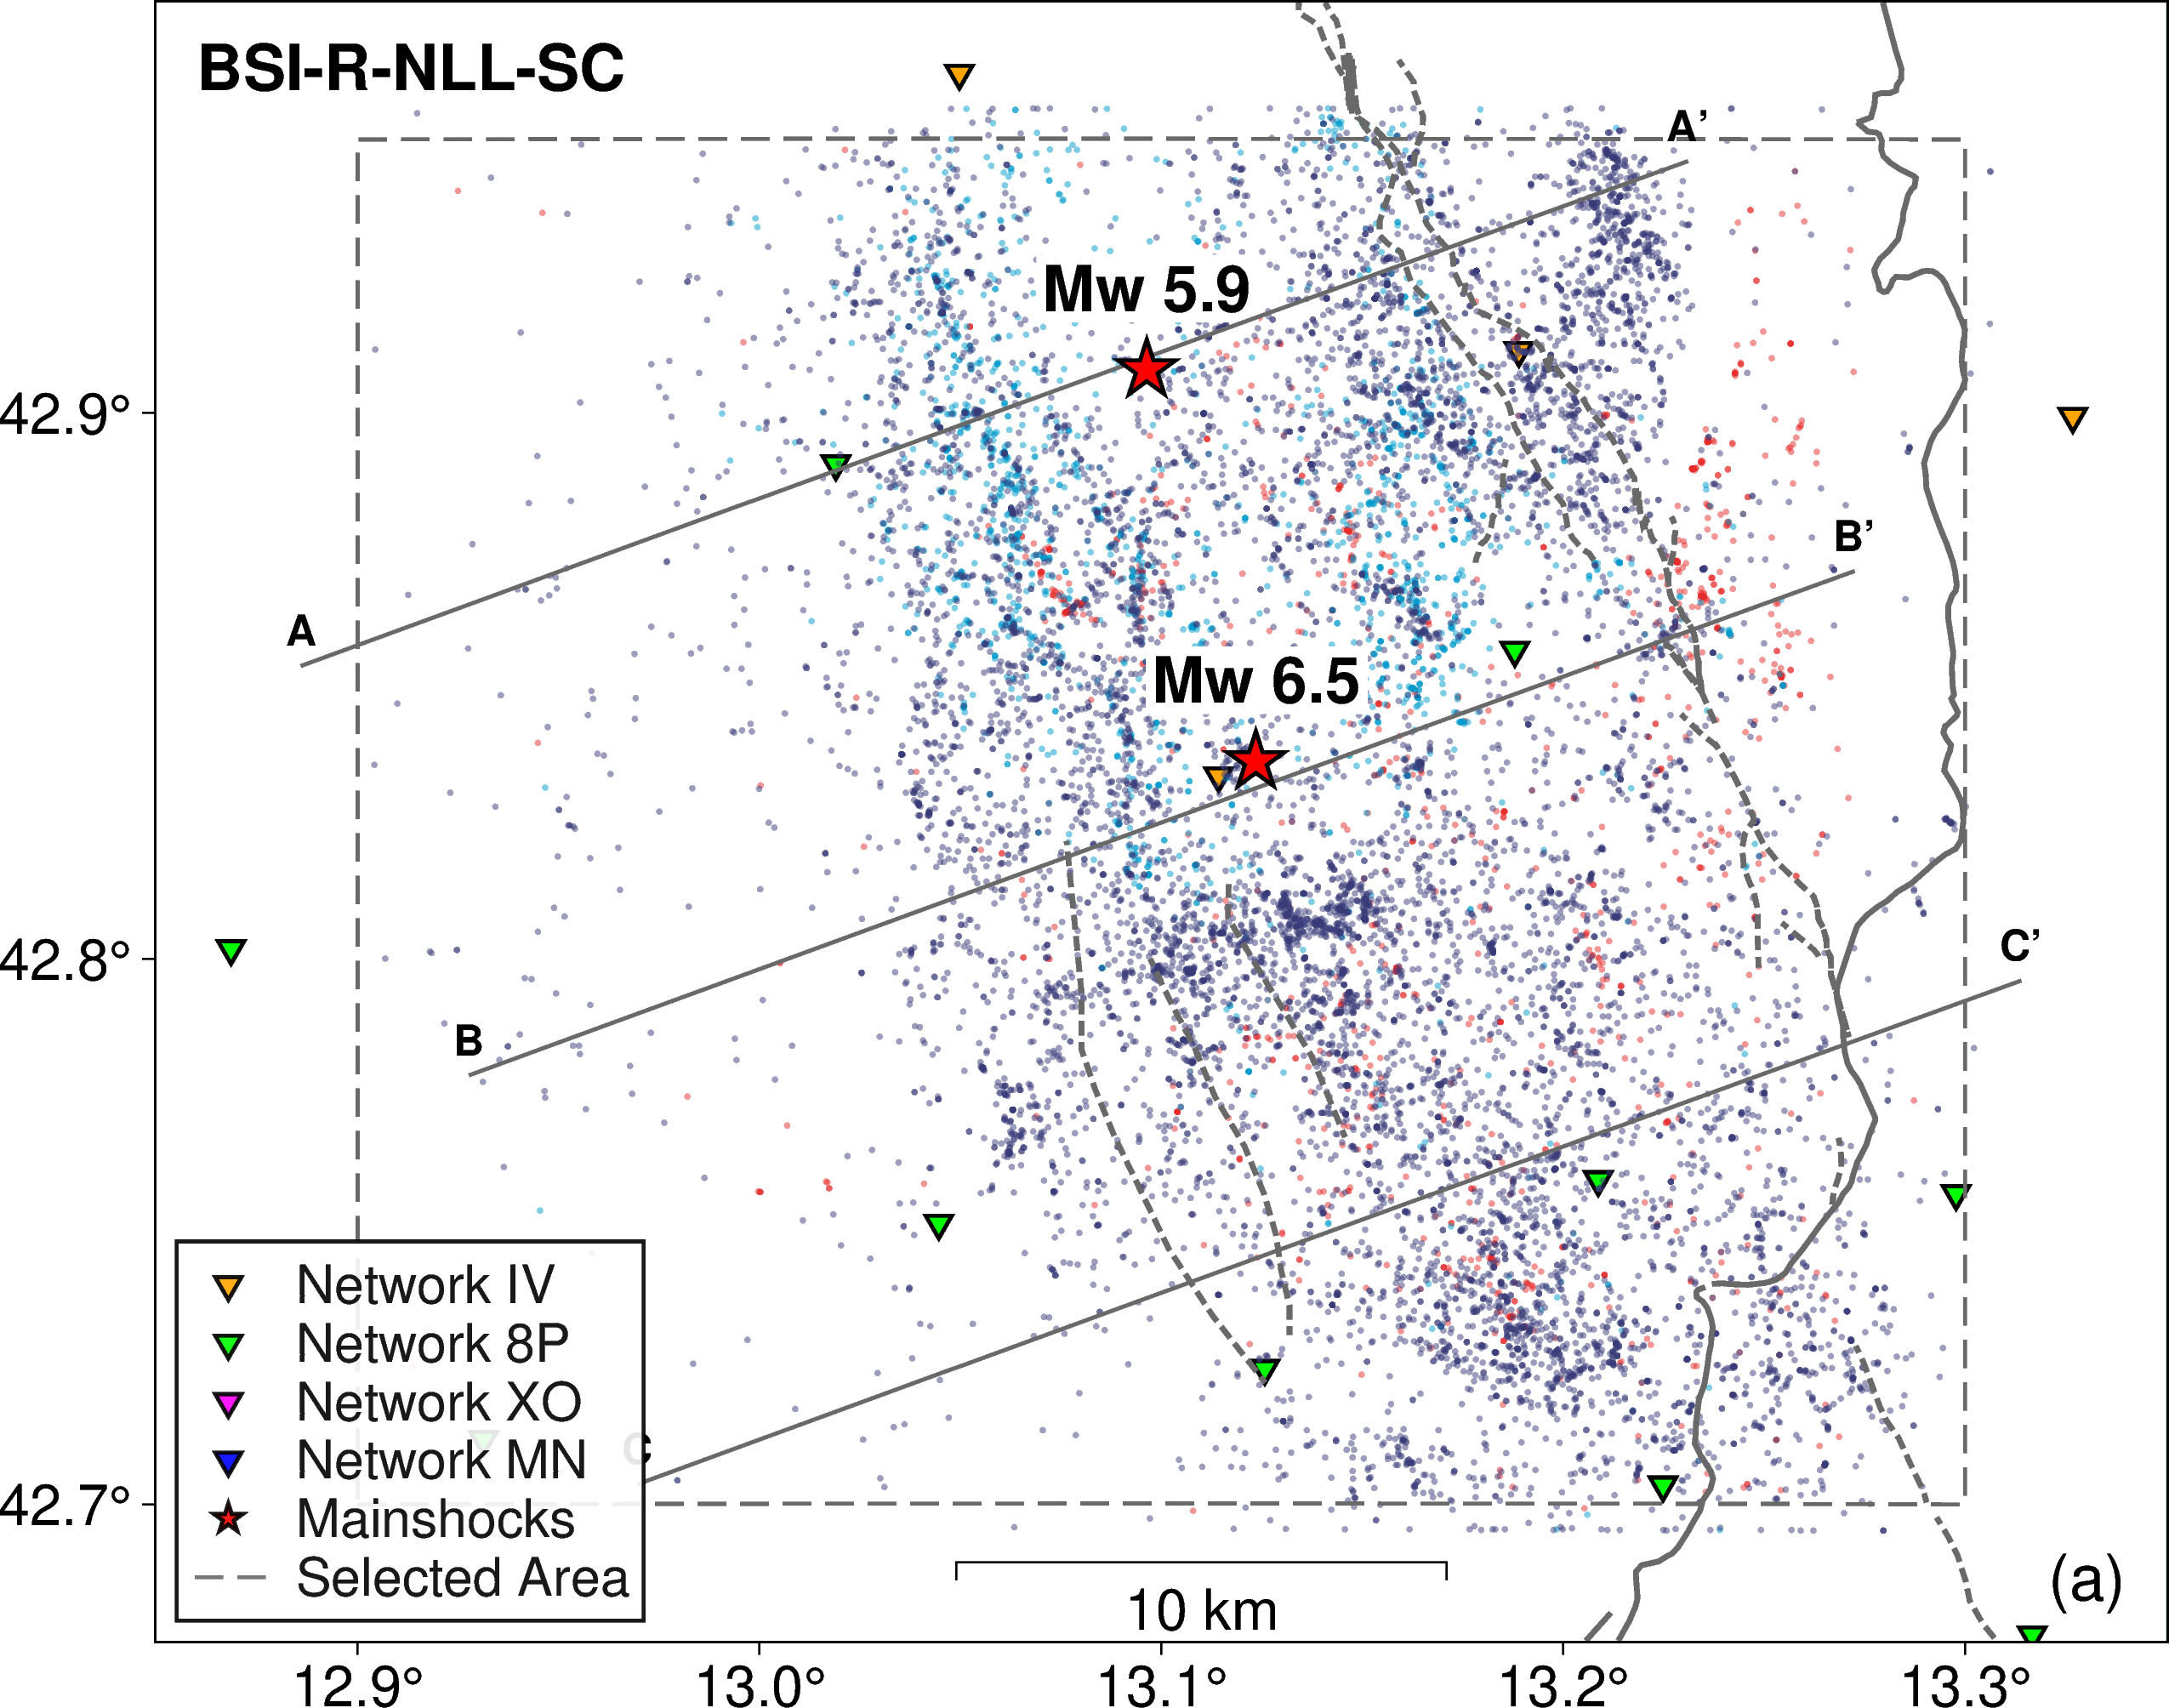

In [15]:
fig = plot_epicenter_time(ingv_nll,"(a)","BSI-R-NLL-SC")


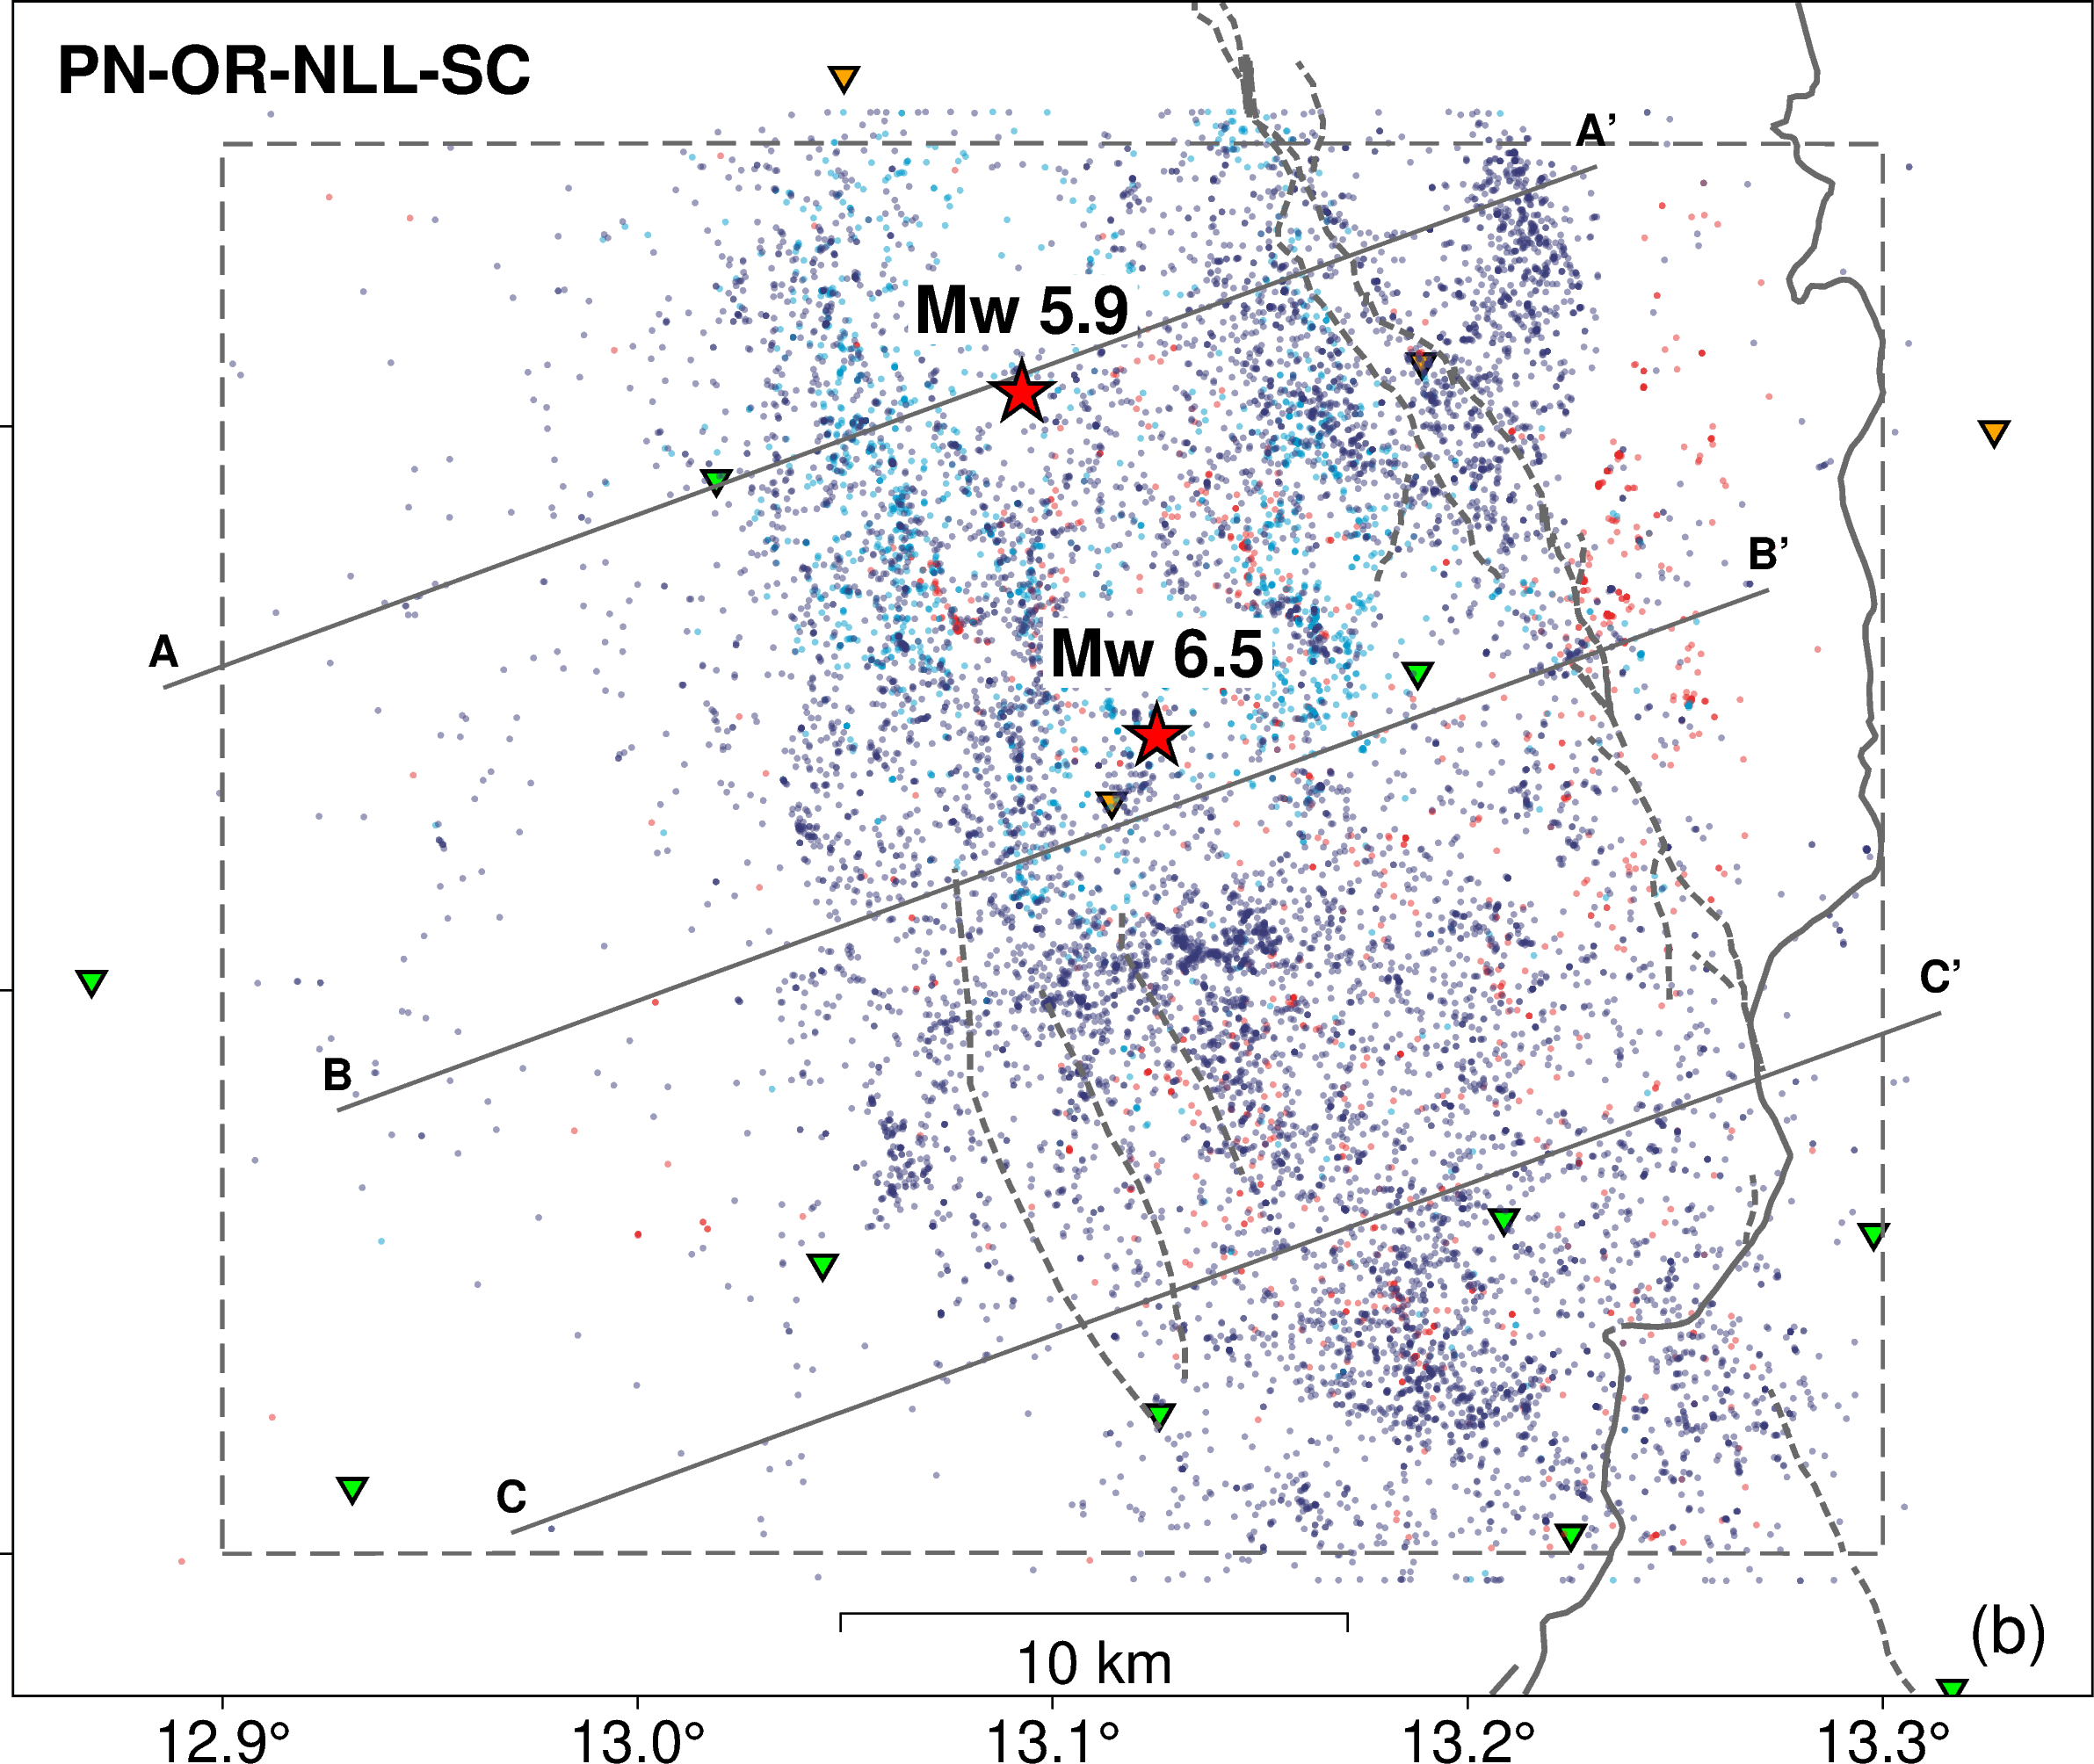

In [16]:
fig = plot_epicenter_time(pn_orig,"(b)","PN-OR-NLL-SC")

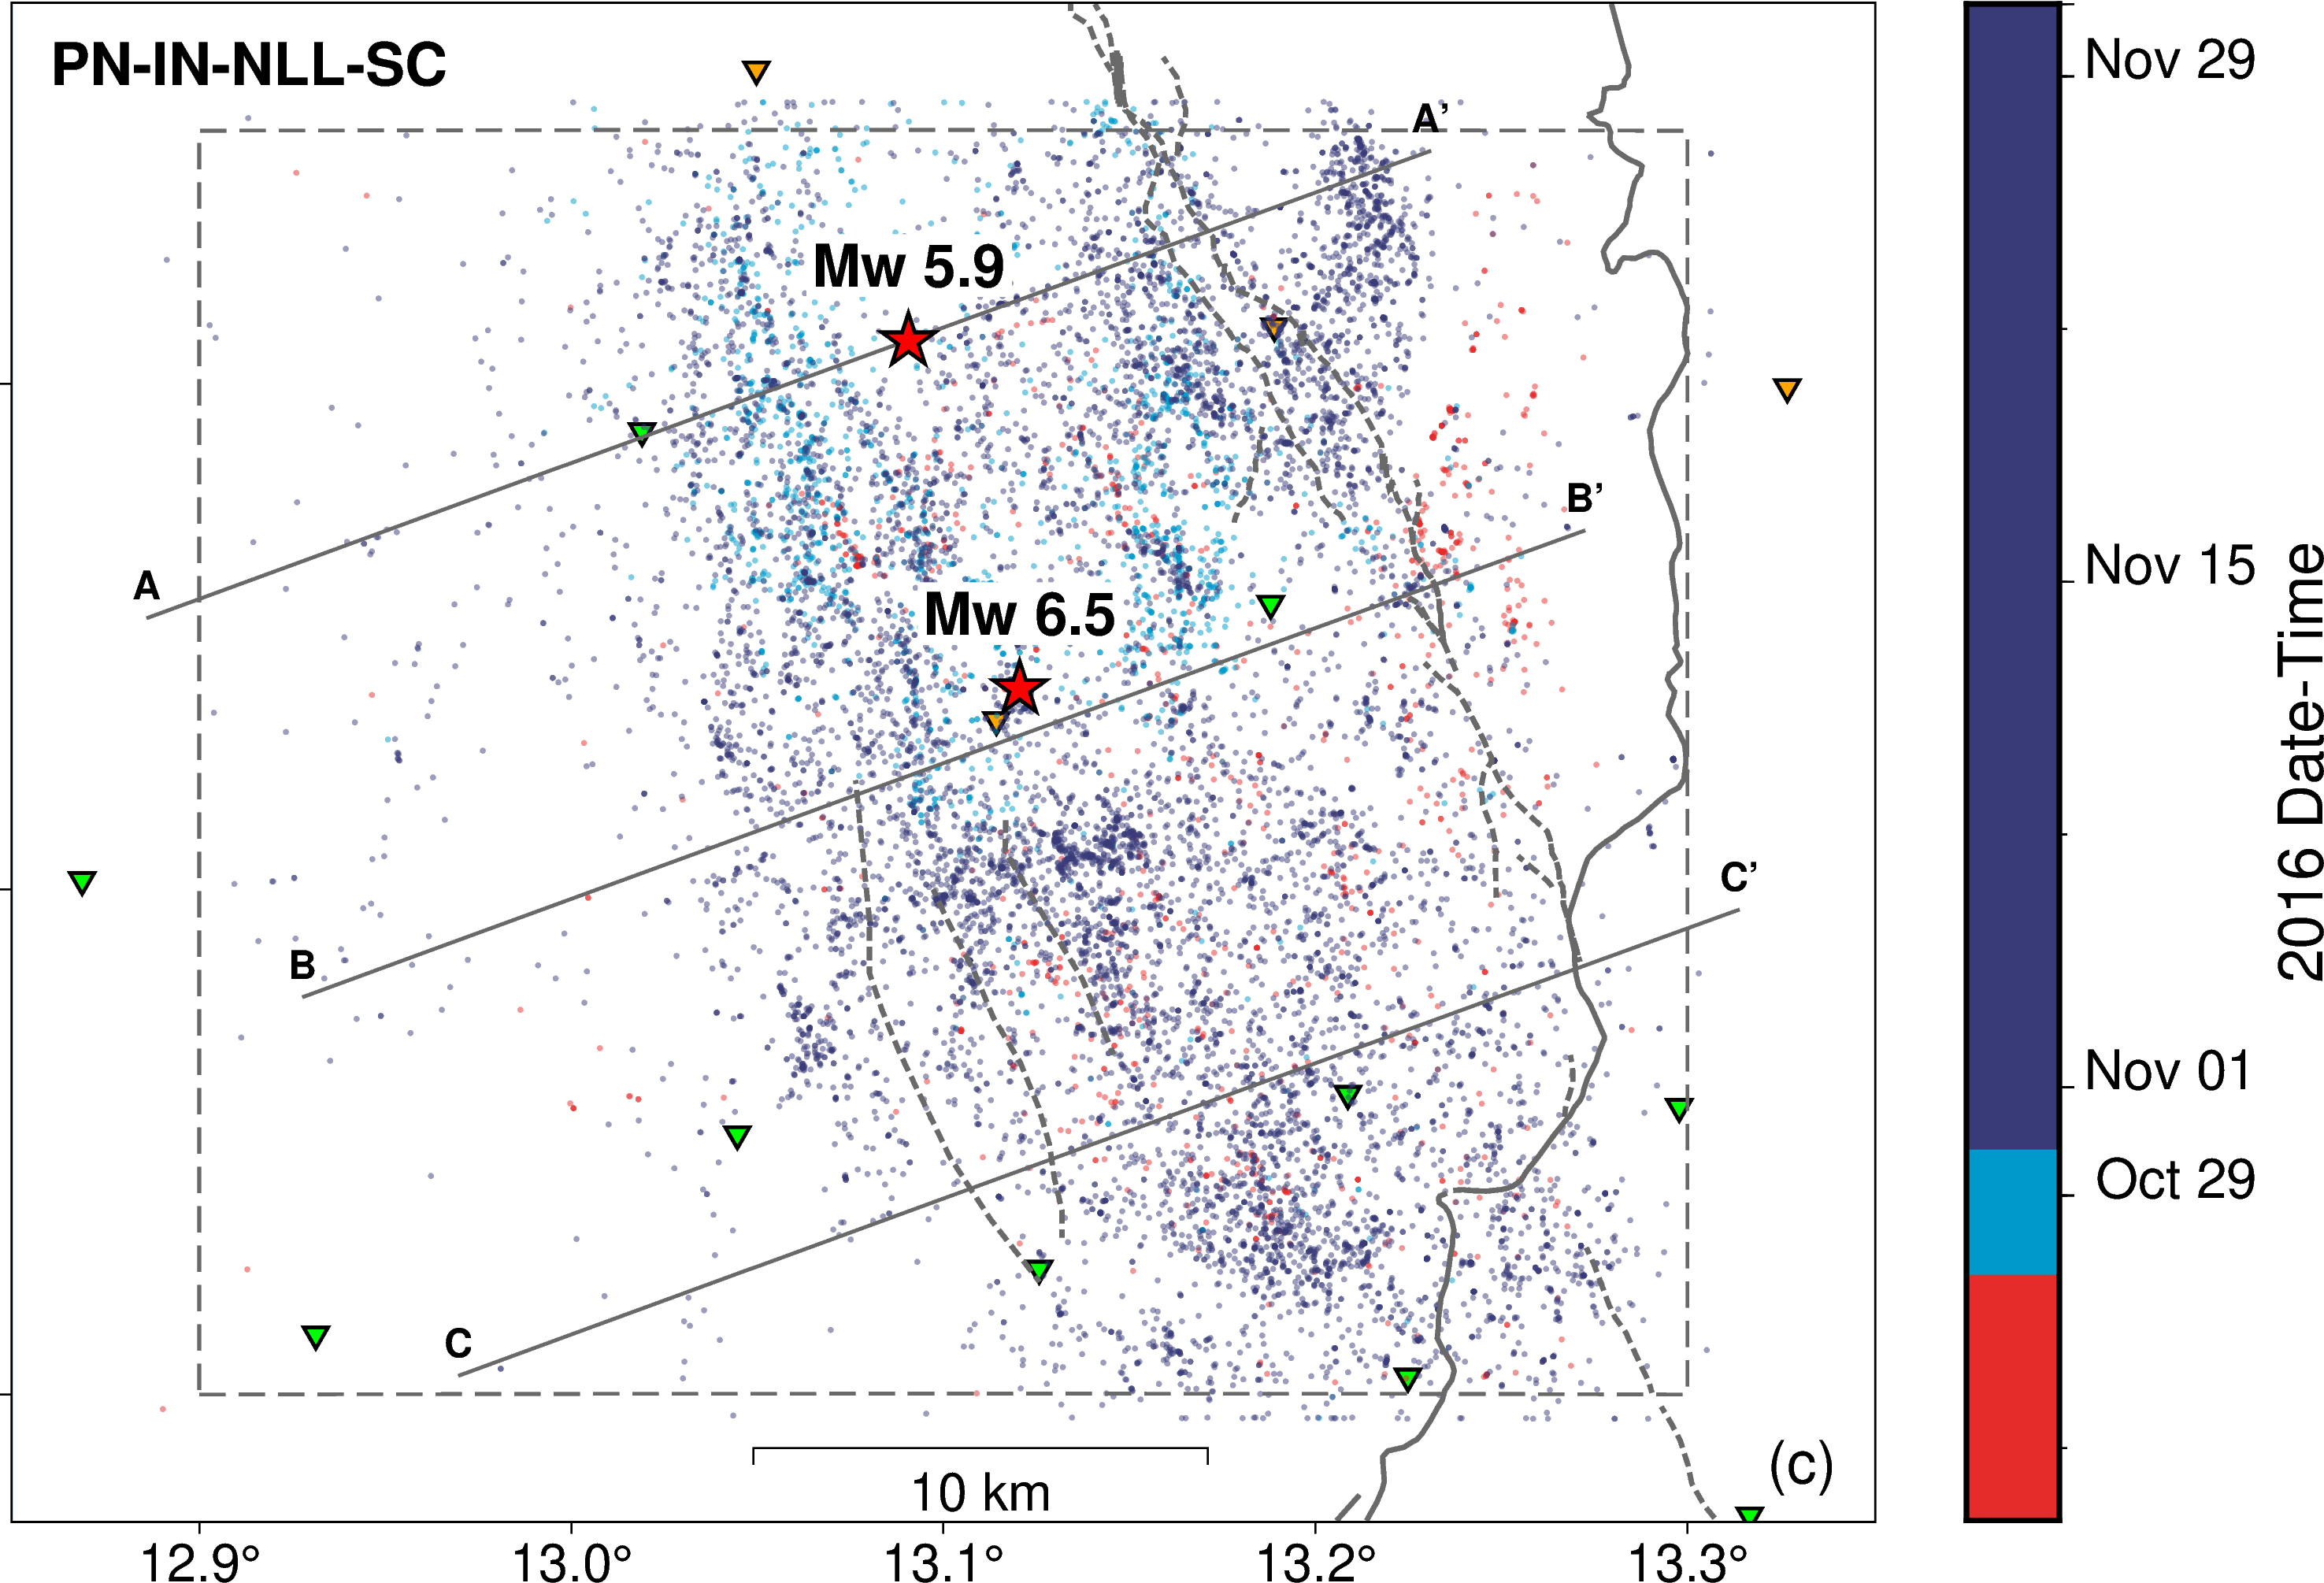

In [17]:
fig = plot_epicenter_time(pn_inst,"(c)","PN-IN-NLL-SC")


# NEW FIGURA 5

In [18]:
def plot_epicenter_sections(df,pan_1,nome):


    # Define the center coordinates
    center = (13.1, 42.825)

    # Define a smaller region around the center with a higher resolution
    lat_range = 0.15  # Latitude range to add/subtract from the center
    lon_range = 0.25  # Longitude range to add/subtract from the center

    # Calculate the region around the center
    region = [
        center[0] - lon_range,  # Western longitude
        center[0] + lon_range,  # Eastern longitude
        center[1] - lat_range,  # Southern latitude
        center[1] + lat_range   # Northern latitude
    ]

    font = "14p,Helvetica"
    font1 = "10p,Helvetica,red"
    font2 = "14p,Helvetica-Bold"
    
    color_1='#E62B2B'
    color_2="#0099CC"
    color_3='#393b79'

    
    transp=50
    wid=[-3,3]
    dim='p0.04c'


    main=df.loc[df['Magnitude']>= 5.5].sort_values(by=['Magnitude'],ascending=True)
    first_event_time = main['date-time'].iloc[0]
    second_event_time = main['date-time'].iloc[1]
    
    df['time_seconds'] =df['date-time'].apply(lambda x: x.timestamp)
    df['color'] = df['date-time'].apply(lambda x: 
                                          color_1 if x <= first_event_time else
                                          color_2 if first_event_time < x <= second_event_time else
                                          color_3)

    # Create the figure
    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain",FONT_ANNOT_PRIMARY="16p", FONT_ANNOT_SECONDARY="16p", FONT_LABEL="18p")

    ti=UTCDateTime("2016-10-20T0:0:0")
    time1 = UTCDateTime("2016-10-26T19:18:06.574000Z")
    time2 = UTCDateTime("2016-10-30T06:40:18.130000Z")
    tf=UTCDateTime("2016-12-1T0:0:0")

    cpt_content = f"""
    # COLOR_MODEL = RGB
    {ti} {color_1} {time1} {color_1}
    {time1} {color_2} {time2} {color_2}
    {time2} {color_3} {tf} {color_3}
    B   85 26 139
    F 255 69 0
    N 255   0   0
    """

    
    with open("time_palette.cpt", "w") as f:
        f.write(cpt_content)

    pygmt.makecpt(cmap="time_palette.cpt")
    

    # ###################### CROSS SECTIONS ACROSS MAINSHOCKS ######################

    # Create a Geod object (WGS84 ellipsoid)
    geod = Geod(ellps="WGS84")
    azimuth = 70  # Azimuth in degrees
    length = 30  # Total length of the cross-section (20 km, meaning 10 km in each direction)


    #### FIRST POINT ####
    center_lon, center_lat = center[0]-lon_range/6, center[1]+lat_range/2
    end2_lon, end2_lat, _ = geod.fwd(center_lon, center_lat, azimuth, length * 1000 / 2)
    end1_lon, end1_lat, _ = geod.fwd(center_lon, center_lat, azimuth + 180, length * 1000 / 2)


    #### SECOND POINT ####
    center_lon2, center_lat2 = center[0], center[1]
    end2_lon2, end2_lat2, _ = geod.fwd(center_lon2, center_lat2, azimuth, length * 1000 / 2)
    end1_lon2, end1_lat2, _ = geod.fwd(center_lon2, center_lat2, azimuth + 180, length * 1000 / 2)

    #### THIRD POINT ####
    center_lon3, center_lat3 = center[0]+lon_range/6, center[1]-lat_range/2
    end2_lon3, end2_lat3, _ = geod.fwd(center_lon3, center_lat3, azimuth, length * 1000 / 2)
    end1_lon3, end1_lat3, _ = geod.fwd(center_lon3, center_lat3, azimuth + 180, length * 1000 / 2)

    
    ###############

    ########### NOW PLOT CROSS SECTIONS ###########

    if pan_1 == "(a)":
        pan_2, pan_3  = "(b)", "(c)"
        frame1 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rsWt+gwhite"]
        frame2 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rsWt+gwhite"]
        frame3 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rSWt+gwhite"]
    if pan_1 == "(d)":
        pan_2, pan_3  = "(e)", "(f)"
        frame1 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rswt+gwhite"]
        frame2 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rswt+gwhite"]
        frame3 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rSwt+gwhite"]
    if pan_1 == "(g)":
        pan_2, pan_3  = "(h)", "(i)"
        frame1 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rswt+gwhite"]
        frame2 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rswt+gwhite"]
        frame3 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rSwt+gwhite"]
    
    
    df_color_1=df.loc[df['color']==color_1]
    df_color_2=df.loc[df['color']==color_2]
    df_color_3=df.loc[df['color']==color_3]
    
    selected_columns_1 = df_color_1[["longitude", "latitude", "depth"]]
    selected_columns_2 = df_color_2[["longitude", "latitude", "depth"]]
    selected_columns_3 = df_color_3[["longitude", "latitude", "depth"]]

    # Save the selected columns to a CSV file
    selected_columns_1.to_csv('selected_columns_1.csv', index=False, sep=" ")
    selected_columns_2.to_csv('selected_columns_2.csv', index=False, sep=" ")
    selected_columns_3.to_csv('selected_columns_3.csv', index=False, sep=" ")
    selected_visso=main[0:1][["longitude", "latitude", "depth"]]
    selected_visso.to_csv('selected_visso.csv', index=False, sep=" ")
    selected_norcia=main[1:2][["longitude", "latitude", "depth"]]
    selected_norcia.to_csv('selected_norcia.csv', index=False, sep=" ")

    pygmt.project(
        data="selected_columns_1.csv",
        unit=True,
        center=[end1_lon, end1_lat],
        endpoint=[end2_lon, end2_lat],
        convention="pz",
        width=wid,
        outfile="cross_a.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_columns_2.csv",
        unit=True,
        center=[end1_lon, end1_lat],
        endpoint=[end2_lon, end2_lat],
        convention="pz",
        width=wid,
        outfile="cross_b.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_columns_3.csv",
        unit=True,
        center=[end1_lon, end1_lat],
        endpoint=[end2_lon, end2_lat],
        convention="pz",
        width=wid,
        outfile="cross_c.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_visso.csv",
        unit=True,
        center=[end1_lon, end1_lat],
        endpoint=[end2_lon, end2_lat],
        convention="pz",
        width=wid,
        outfile="visso.dat",
        output_type="file",
    )

    df_cross_a = pd.read_csv("cross_a.dat", sep='\s+', names=["x", "y"])
    df_cross_a['color'] = color_1
    df_cross_b = pd.read_csv("cross_b.dat", sep='\s+', names=["x", "y"])
    df_cross_b['color'] = color_2
    df_cross_c = pd.read_csv("cross_c.dat", sep='\s+', names=["x", "y"])
    df_cross_c['color'] = color_3
    df_cross = pd.concat([df_cross_a, df_cross_b, df_cross_c], axis=0)
    df_cross = df_cross.reset_index(drop=True)

    df_visso=pd.read_csv("visso.dat", sep='\s+', names=["x", "y"])
    
    with pygmt.config(MAP_FRAME_TYPE="plain"):
        fig.basemap(
            projection="X10/-5",
            region=[0, 30, 0, 15],
            frame=frame1,
        )

    for _, row in df_cross.iterrows():
        fig.plot(x=row['x'], y=row['y'], style=dim, fill=row['color'], pen=row['color'],transparency=transp)

    ## Add yellow star mainshok to cross section
    fig.plot(x=df_visso['x'], y=df_visso['y'],
        style="a0.3c",  # Style for the points (e.g., triangle markers)
        fill="yellow",  # Color for the points
        pen="1p,black",  # Outline for the points
        transparency = 50,   
        )

    fig.text(x=1, y=-1, text="A", fill="white",font="12,Helvetica-Bold",clearance="0.1c",no_clip=True)
    fig.text(x=29, y=-1, text="A'", fill="white",font="12,Helvetica-Bold",clearance="0.1c",no_clip=True)
    fig.text(text=pan_1, position="BR", font=font, justify="BR",  offset="-0.4c/0.4c")


    fig.text(
    x=1, y=14,   # coordinate in km all’interno del pannello
    text=nome,
    font=font2,
    justify="BL"    # giustificazione rispetto al punto scelto
)

    # Plot a rectangle with the given coordinates
    fig.plot(
        x=[20, 30, 30, 20, 20],  # Longitudes of the rectangle
        y=[0, 0, 5, 5, 0],  # Latitudes of the rectangle
        pen="0.5p,red",  # Red line with 2 point thickness
        label="Selected Area"  # Label for the rectangle (optional)
    )

    fig.text(
    x=29.5, y=4.5,   # coordinate in km all’interno del pannello
    text="FW1",
    font=font1,
    justify="BR"    # giustificazione rispetto al punto scelto
)

    ####################################################


    pygmt.project(
        data="selected_columns_1.csv",
        unit=True,
        center=[end1_lon2, end1_lat2],
        endpoint=[end2_lon2, end2_lat2],
        convention="pz",
        width=wid,
        outfile="cross_a.dat",
        output_type="file",
    )
    
    pygmt.project(
        data="selected_columns_2.csv",
        unit=True,
        center=[end1_lon2, end1_lat2],
        endpoint=[end2_lon2, end2_lat2],
        convention="pz",
        width=wid,
        outfile="cross_b.dat",
        output_type="file",
    )
    pygmt.project(
        data="selected_norcia.csv",
        unit=True,
        center=[end1_lon2, end1_lat2],
        endpoint=[end2_lon2, end2_lat2],
        convention="pz",
        width=wid,
        outfile="norcia.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_columns_3.csv",
        unit=True,
        center=[end1_lon2, end1_lat2],
        endpoint=[end2_lon2, end2_lat2],
        convention="pz",
        width=wid,
        outfile="cross_c.dat",
        output_type="file",
    )

    df_cross_a = pd.read_csv("cross_a.dat", sep='\s+', names=["x", "y"])
    df_cross_a['color'] = color_1
    df_cross_b = pd.read_csv("cross_b.dat", sep='\s+', names=["x", "y"])
    df_cross_b['color'] = color_2
    df_cross_c = pd.read_csv("cross_c.dat", sep='\s+', names=["x", "y"])
    df_cross_c['color'] = color_3
    df_cross = pd.concat([df_cross_a, df_cross_b, df_cross_c], axis=0)
    df_cross = df_cross.reset_index(drop=True)

    # df_norcia=pd.read_csv("norcia.dat", sep='\s+', names=["x", "y"])
    df_norcia = pd.read_csv("norcia.dat", sep='\s+', names=["x", "y"])
    df_norcia = df_norcia.apply(pd.to_numeric, errors='coerce')  # converte in float
    df_norcia = df_norcia.dropna()  # elimina eventuali righe non numeriche

    
    fig.shift_origin(yshift=-5.80)
    with pygmt.config(MAP_FRAME_TYPE="plain"):
        fig.basemap(
            projection="X10/-5",
            region=[0, 30, 0, 15],
            frame=frame2,
        )
    for _, row in df_cross.iterrows():
        fig.plot(x=row['x'], y=row['y'], style=dim, fill=row['color'], pen=row['color'],transparency=transp)

    ## Add yellow star mainshok to cross section
    fig.plot(x=df_norcia['x'], y=df_norcia['y'],         
        style="a0.3c",  # Style for the points (e.g., triangle markers)
        fill="yellow",  # Color for the points
        pen="1p,black",  # Outline for the points
        transparency = 50,
        )
    fig.text(x=1, y=-1, text="B", fill="white",font="12,Helvetica-Bold",clearance="0.1c",no_clip=True)
    fig.text(x=29, y=-1, text="B'", fill="white",font="12,Helvetica-Bold",clearance="0.1c",no_clip=True)
    fig.text(text=pan_2, position="BR", font=font, justify="BR",  offset="-0.4c/0.4c")

    # Plot a rectangle with the given coordinates
    fig.plot(
        x=[10, 20, 20, 10, 10],  # Longitudes of the rectangle
        y=[5, 5, 10, 10, 5],  # Latitudes of the rectangle
        pen="0.5p,red",  # Red line with 2 point thickness
        label="Selected Area"  # Label for the rectangle (optional)
    )
    fig.text(
    x=19.5, y=9.5,   # coordinate in km all’interno del pannello
    text="FW2",
    font=font1,
    justify="BR"    # giustificazione rispetto al punto scelto
)

    fig.plot(
        x=[20, 30, 30, 20, 20],  # Longitudes of the rectangle
        y=[10, 10, 15, 15, 10],  # Latitudes of the rectangle
        pen="0.5p,red",  # Red line with 2 point thickness
        label="Selected Area"  # Label for the rectangle (optional)
    )
    fig.text(
    x=29.5, y=12.5,   # coordinate in km all’interno del pannello
    text="FW3",
    font=font1,
    justify="BR"    # giustificazione rispetto al punto scelto
)


    ####################################################



    pygmt.project(
        data="selected_columns_1.csv",
        unit=True,
        center=[end1_lon3, end1_lat3],
        endpoint=[end2_lon3, end2_lat3],
        convention="pz",
        width=wid,
        outfile="cross_a.dat",
        output_type="file",
    )
    
    pygmt.project(
        data="selected_columns_2.csv",
        unit=True,
        center=[end1_lon3, end1_lat3],
        endpoint=[end2_lon3, end2_lat3],
        convention="pz",
        width=wid,
        outfile="cross_b.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_columns_3.csv",
        unit=True,
        center=[end1_lon3, end1_lat3],
        endpoint=[end2_lon3, end2_lat3],
        convention="pz",
        width=wid,
        outfile="cross_c.dat",
        output_type="file",
    )

    df_cross_a = pd.read_csv("cross_a.dat", sep='\s+', names=["x", "y"])
    df_cross_a['color'] = color_1
    df_cross_b = pd.read_csv("cross_b.dat", sep='\s+', names=["x", "y"])
    df_cross_b['color'] = color_2
    df_cross_c = pd.read_csv("cross_c.dat", sep='\s+', names=["x", "y"])
    df_cross_c['color'] = color_3
    df_cross = pd.concat([df_cross_a, df_cross_b, df_cross_c], axis=0)
    df_cross = df_cross.reset_index(drop=True)

    fig.shift_origin(yshift=-5.80)
    with pygmt.config(MAP_FRAME_TYPE="plain"):
        fig.basemap(
            projection="X10/-5",
            region=[0, 30, 0, 15],
            frame=frame3,
        )
    for _, row in df_cross.iterrows():
        fig.plot(x=row['x'], y=row['y'], style=dim, fill=row['color'], pen=row['color'],transparency=transp)
    fig.text(x=1, y=-1, text="C", fill="white",font="12,Helvetica-Bold",clearance="0.1c",no_clip=True)
    fig.text(x=29, y=-1, text="C'", fill="white",font="12,Helvetica-Bold",clearance="0.1c",no_clip=True)
    fig.text(text=pan_3, position="BR", font=font, justify="BR", offset="-0.4c/0.4c")
    if pan_1 == "(g)":
        fig.colorbar(
            frame='af+l2016 Date-Time+e',  # Add arrows to indicate out-of-range values f
            position="JMR+w16.3c/1.c+o1.0c/5.65c",  # Position the colorbar on the right with some offset
            cmap="time_palette.cpt",  # Use the colormap defined earlier
        )
    fig.plot(
    x=[9, 27, 27, 9, 9],  # Longitudes of the rectangle
    y=[5, 5, 12, 12, 5],  # Latitudes of the rectangle
    pen="0.5p,red",  # Red line with 2 point thickness
    label="Selected Area"  # Label for the rectangle (optional)
    )
    fig.text(
    x=25.5, y=11.5,   # coordinate in km all’interno del pannello
    text="FW4",
    font=font1,
    justify="BR"    # giustificazione rispetto al punto scelto
    )
    
    # Save the figure
    fig.savefig("FIGURE/map_"+nome+"_time_section.png",dpi=300)

    # Display the figure
    fig.show()


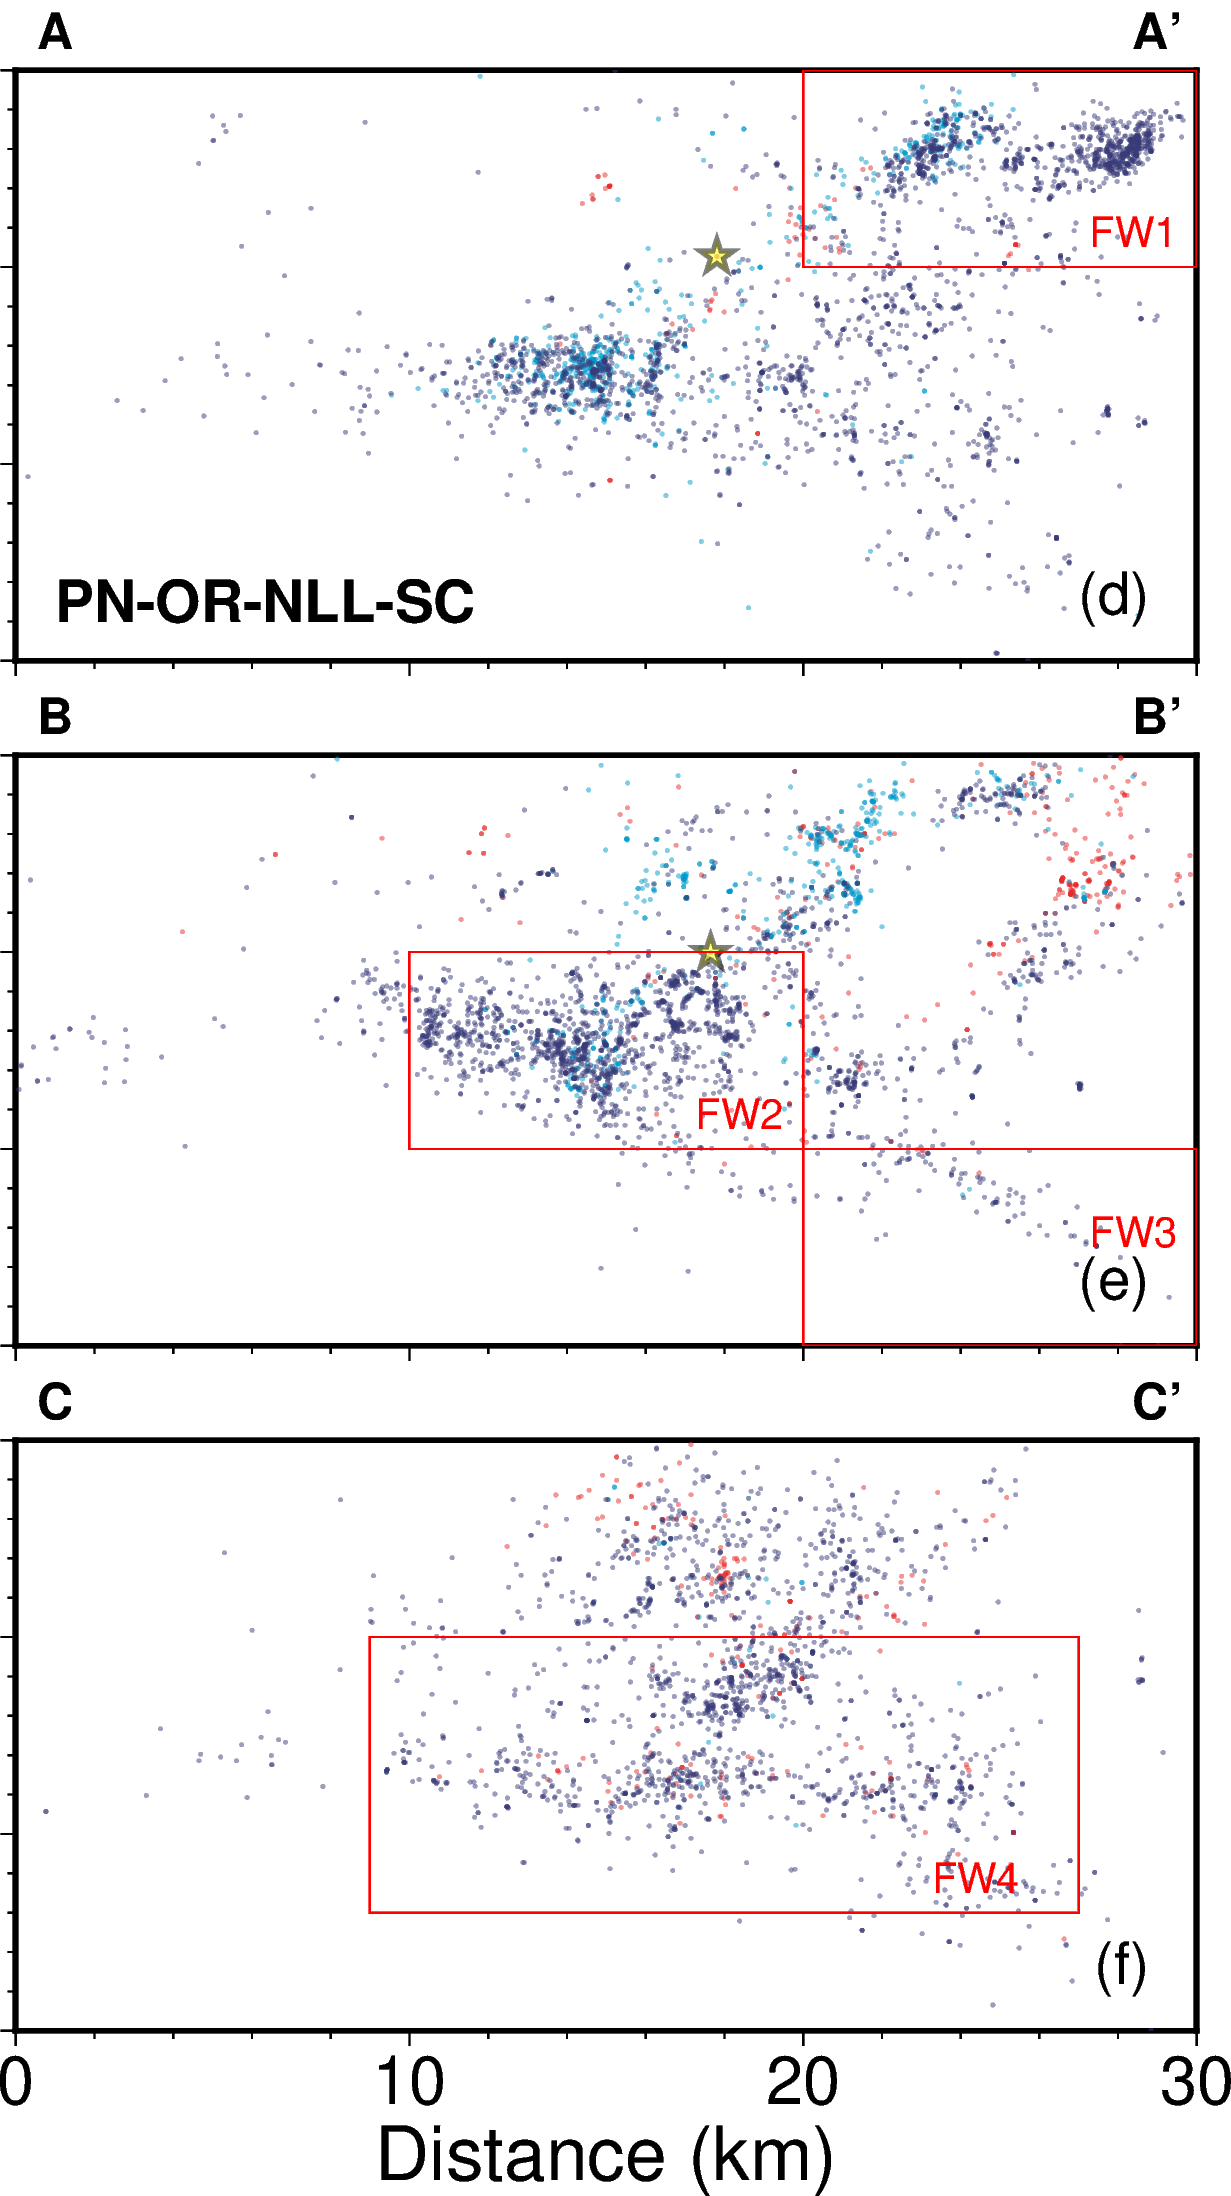

In [19]:
fig = plot_epicenter_sections(pn_orig,"(d)","PN-OR-NLL-SC")

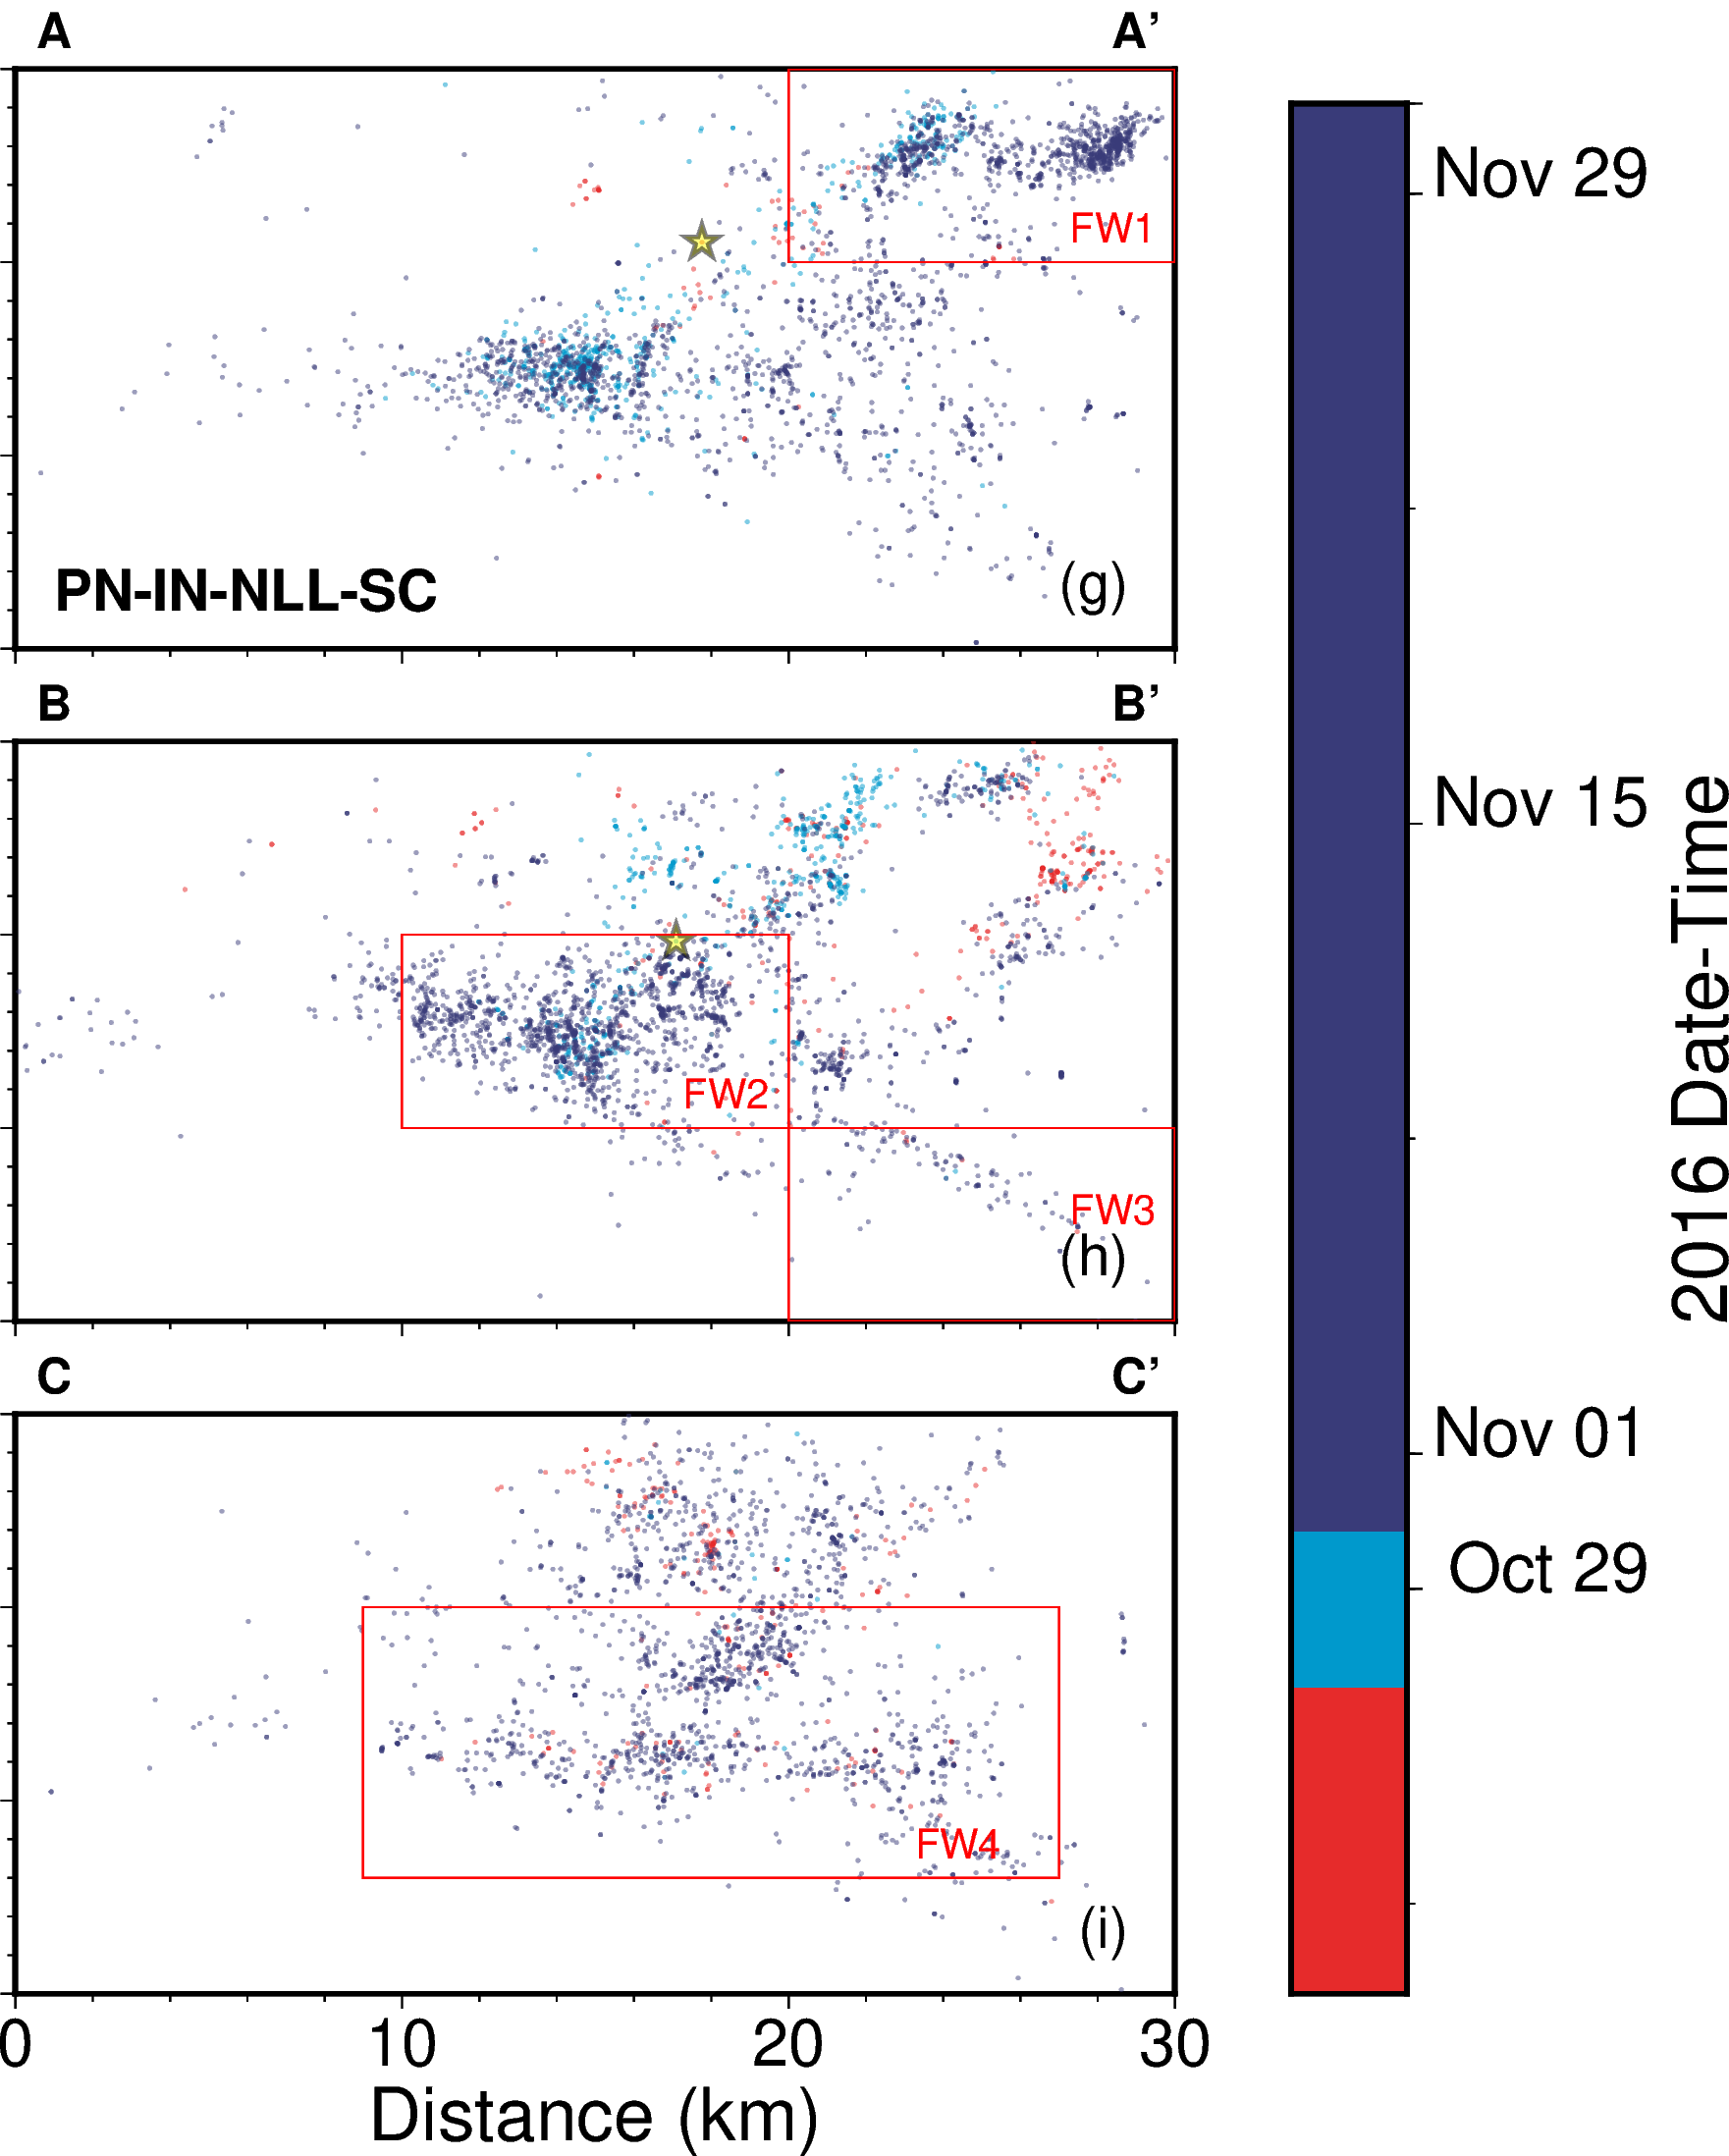

In [20]:
fig = plot_epicenter_sections(pn_inst,"(g)","PN-IN-NLL-SC")

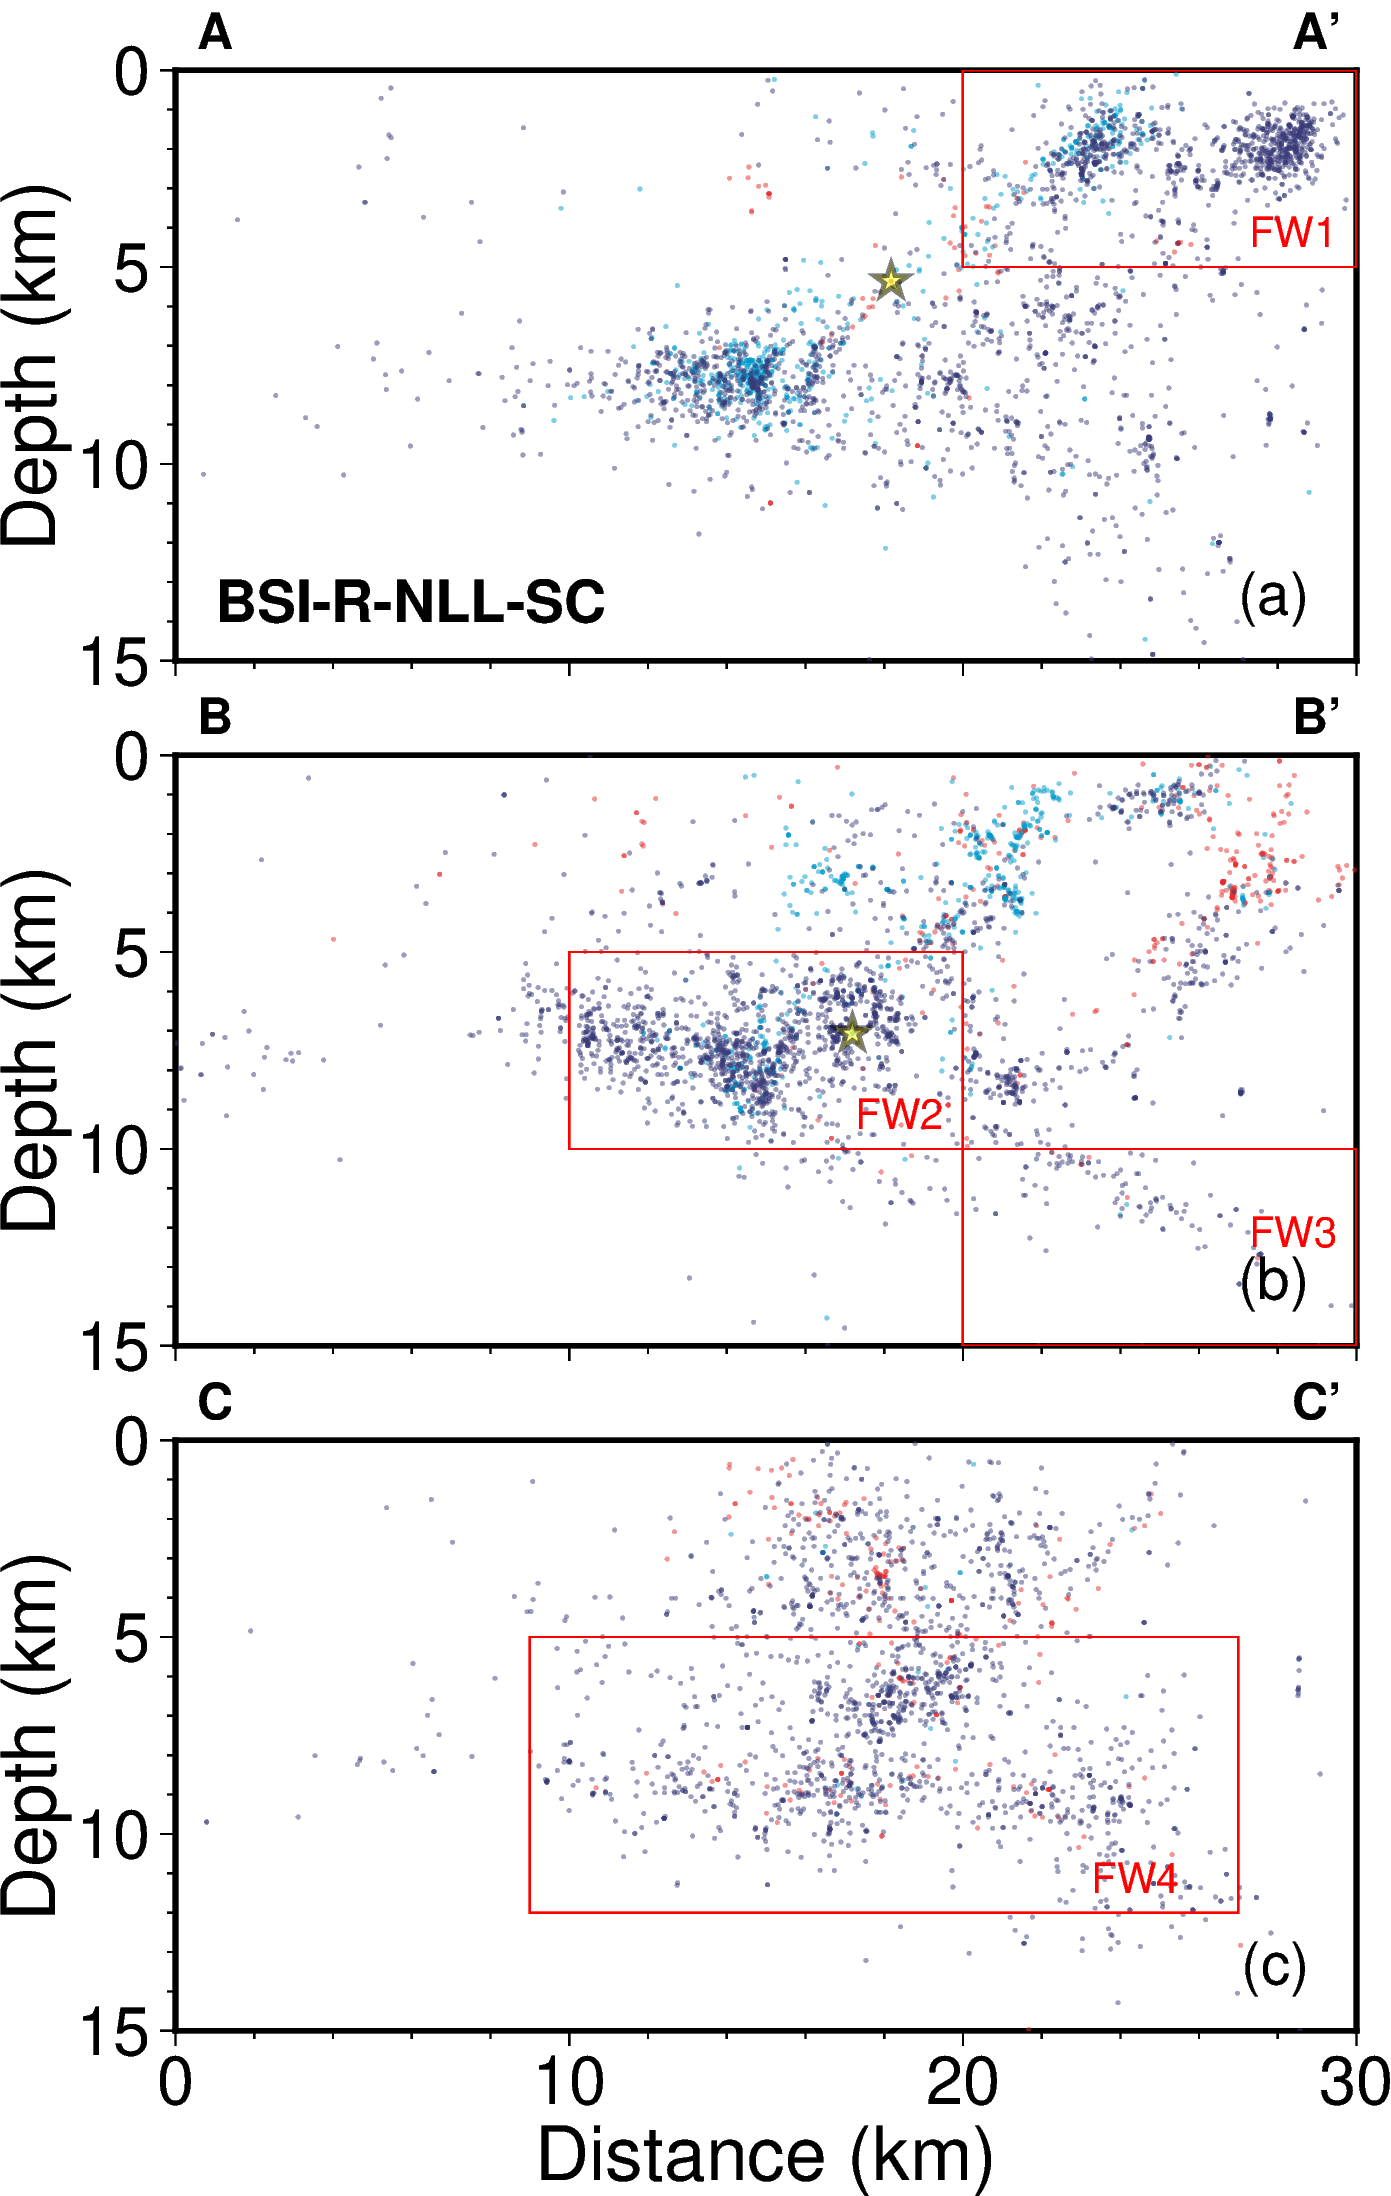

In [21]:
fig = plot_epicenter_sections(ingv_nll,"(a)","BSI-R-NLL-SC")

# FIGURE ZOOM for Supplement

In [22]:
def plot_epicenter_zoom(df,pan_1,nome):


    # Define the center coordinates
    center = (13.1, 42.825)

    # Define a smaller region around the center with a higher resolution
    lat_range = 0.15  # Latitude range to add/subtract from the center
    lon_range = 0.25  # Longitude range to add/subtract from the center

    # Calculate the region around the center
    region = [
        center[0] - lon_range,  # Western longitude
        center[0] + lon_range,  # Eastern longitude
        center[1] - lat_range,  # Southern latitude
        center[1] + lat_range   # Northern latitude
    ]

    font = "14p,Helvetica"
    font2 = "14p,Helvetica-Bold"
    
    ## Define colors
    color_1='#E62B2B'
    color_2="#0099CC"
    color_3='#393b79'

    transp=50
    wid=[-3,3]
    dim='p0.06c'


    main=df.loc[df['Magnitude']>= 5.5].sort_values(by=['Magnitude'],ascending=True)
    first_event_time = main['date-time'].iloc[0]
    second_event_time = main['date-time'].iloc[1]
    

    # Aggiungo la colonna 'date-time' in secondi dall'epoca
    df['time_seconds'] =df['date-time'].apply(lambda x: x.timestamp)
    
    # Crea una nuova colonna 'color' nel dataframe basata sui confronti delle date
    df['color'] = df['date-time'].apply(lambda x: 
                                          color_1 if x <= first_event_time else
                                          color_2 if first_event_time < x <= second_event_time else
                                          color_3)

    # Create the figure
    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain",FONT_ANNOT_PRIMARY="16p", FONT_ANNOT_SECONDARY="16p", FONT_LABEL="18p")

    ti=UTCDateTime("2016-10-20T0:0:0")
    time1 = UTCDateTime("2016-10-26T19:18:06.574000Z")
    time2 = UTCDateTime("2016-10-30T06:40:18.130000Z")
    tf=UTCDateTime("2016-12-1T0:0:0")

    cpt_content = f"""
    # COLOR_MODEL = RGB
    {ti} {color_1} {time1} {color_1}
    {time1} {color_2} {time2} {color_2}
    {time2} {color_3} {tf} {color_3}
    B   85 26 139
    F 255 69 0
    N 255   0   0
    """

    with open("time_palette.cpt", "w") as f:
        f.write(cpt_content)
    pygmt.makecpt(cmap="time_palette.cpt")
    

    # ###################### CROSS SECTIONS ACROSS MAINSHOCKS ######################

    # Create a Geod object (WGS84 ellipsoid)
    geod = Geod(ellps="WGS84")
    azimuth = 70  # Azimuth in degrees
    length = 30  # Total length of the cross-section (20 km, meaning 10 km in each direction)


    #### FIRST POINT ####
    center_lon, center_lat = center[0]-lon_range/6, center[1]+lat_range/2
    end2_lon, end2_lat, _ = geod.fwd(center_lon, center_lat, azimuth, length * 1000 / 2)
    end1_lon, end1_lat, _ = geod.fwd(center_lon, center_lat, azimuth + 180, length * 1000 / 2)


    #### SECOND POINT ####
    center_lon2, center_lat2 = center[0], center[1]
    end2_lon2, end2_lat2, _ = geod.fwd(center_lon2, center_lat2, azimuth, length * 1000 / 2)
    end1_lon2, end1_lat2, _ = geod.fwd(center_lon2, center_lat2, azimuth + 180, length * 1000 / 2)

    #### THIRD POINT ####
    center_lon3, center_lat3 = center[0]+lon_range/6, center[1]-lat_range/2
    end2_lon3, end2_lat3, _ = geod.fwd(center_lon3, center_lat3, azimuth, length * 1000 / 2)
    end1_lon3, end1_lat3, _ = geod.fwd(center_lon3, center_lat3, azimuth + 180, length * 1000 / 2)

    
    ###############

    ########### NOW PLOT CROSS SECTIONS ###########

    if pan_1 == "(a)":
        pan_2, pan_3  = "(b)", "(c)"
        frame1 = ['xafg100', 'yafg50+lDepth (km)', "rSWt+gwhite"]
        frame2 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rSWt+gwhite"]
    if pan_1 == "(d)":
        pan_2, pan_3  = "(e)", "(f)"
        frame1 = ['xafg100', 'yafg50+lDepth (km)', "rSwt+gwhite"]
        frame2 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rSwt+gwhite"]
    if pan_1 == "(g)":
        pan_2, pan_3  = "(h)", "(i)"
        frame1 = ['xafg100', 'yafg50+lDepth (km)', "rSwt+gwhite"]
        frame2 = ['xafg100+lDistance (km)', 'yafg50+lDepth (km)', "rSwt+gwhite"]

    
    df_color_1=df.loc[df['color']==color_1]
    df_color_2=df.loc[df['color']==color_2]
    df_color_3=df.loc[df['color']==color_3]
    
    selected_columns_1 = df_color_1[["longitude", "latitude", "depth"]]
    selected_columns_2 = df_color_2[["longitude", "latitude", "depth"]]
    selected_columns_3 = df_color_3[["longitude", "latitude", "depth"]]

    # Save the selected columns to a CSV file
    selected_columns_1.to_csv('selected_columns_1.csv', index=False, sep=" ")
    selected_columns_2.to_csv('selected_columns_2.csv', index=False, sep=" ")
    selected_columns_3.to_csv('selected_columns_3.csv', index=False, sep=" ")
    selected_visso=main[0:1][["longitude", "latitude", "depth"]]
    selected_visso.to_csv('selected_visso.csv', index=False, sep=" ")
    selected_norcia=main[1:2][["longitude", "latitude", "depth"]]
    selected_norcia.to_csv('selected_norcia.csv', index=False, sep=" ")

    pygmt.project(
        data="selected_columns_1.csv",
        unit=True,
        center=[end1_lon, end1_lat],
        endpoint=[end2_lon, end2_lat],
        convention="pz",
        width=wid,
        outfile="cross_a.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_columns_2.csv",
        unit=True,
        center=[end1_lon, end1_lat],
        endpoint=[end2_lon, end2_lat],
        convention="pz",
        width=wid,
        outfile="cross_b.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_columns_3.csv",
        unit=True,
        center=[end1_lon, end1_lat],
        endpoint=[end2_lon, end2_lat],
        convention="pz",
        width=wid,
        outfile="cross_c.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_visso.csv",
        unit=True,
        center=[end1_lon, end1_lat],
        endpoint=[end2_lon, end2_lat],
        convention="pz",
        width=wid,
        outfile="visso.dat",
        output_type="file",
    )

    df_cross_a = pd.read_csv("cross_a.dat", sep='\s+', names=["x", "y"])
    df_cross_a['color'] = color_1
    df_cross_b = pd.read_csv("cross_b.dat", sep='\s+', names=["x", "y"])
    df_cross_b['color'] = color_2
    df_cross_c = pd.read_csv("cross_c.dat", sep='\s+', names=["x", "y"])
    df_cross_c['color'] = color_3
    df_cross = pd.concat([df_cross_a, df_cross_b, df_cross_c], axis=0)
    df_cross = df_cross.reset_index(drop=True)
    
    df_visso=pd.read_csv("visso.dat", sep='\s+', names=["x", "y"])
    

    zooms = [
        ([20, 30, 0, 5], "FW1")
    ]

    for i, (region2, label) in enumerate(zooms):
        with pygmt.config(MAP_FRAME_TYPE="plain"):
            fig.basemap(
                projection="X10c/-5c",
                region=region2,
                frame=frame1
            )
        subset = df_cross[
            (df_cross["x"] >= region2[0]) & (df_cross["x"] <= region2[1]) &
            (df_cross["y"] >= region2[2]) & (df_cross["y"] <= region2[3])
        ]

        for _, row in subset.iterrows():
            fig.plot(x=row['x'], y=row['y'], style=dim, fill=row['color'], pen=row['color'],transparency=transp)
        
        fig.text(
            text=zooms[0][1],
            position="BR",
            font="10p,Helvetica-Bold,red",
            offset="-0.5c/0.3c"
        )

    
    ####################################################


    pygmt.project(
        data="selected_columns_1.csv",
        unit=True,
        center=[end1_lon2, end1_lat2],
        endpoint=[end2_lon2, end2_lat2],
        convention="pz",
        width=wid,
        outfile="cross_a.dat",
        output_type="file",
    )
    
    pygmt.project(
        data="selected_columns_2.csv",
        unit=True,
        center=[end1_lon2, end1_lat2],
        endpoint=[end2_lon2, end2_lat2],
        convention="pz",
        width=wid,
        outfile="cross_b.dat",
        output_type="file",
    )
    pygmt.project(
        data="selected_norcia.csv",
        unit=True,
        center=[end1_lon2, end1_lat2],
        endpoint=[end2_lon2, end2_lat2],
        convention="pz",
        width=wid,
        outfile="norcia.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_columns_3.csv",
        unit=True,
        center=[end1_lon2, end1_lat2],
        endpoint=[end2_lon2, end2_lat2],
        convention="pz",
        width=wid,
        outfile="cross_c.dat",
        output_type="file",
    )

    df_cross_a = pd.read_csv("cross_a.dat", sep='\s+', names=["x", "y"])
    df_cross_a['color'] = color_1
    df_cross_b = pd.read_csv("cross_b.dat", sep='\s+', names=["x", "y"])
    df_cross_b['color'] = color_2
    df_cross_c = pd.read_csv("cross_c.dat", sep='\s+', names=["x", "y"])
    df_cross_c['color'] = color_3
    df_cross = pd.concat([df_cross_a, df_cross_b, df_cross_c], axis=0)
    df_cross = df_cross.reset_index(drop=True)

    df_norcia=pd.read_csv("norcia.dat", sep='\s+', names=["x", "y"])

    zooms = [
        ([10, 20, 5, 10], "FW2"),
        ([20, 30, 10, 15], "FW3")
    ]

    for i, (region2, label) in enumerate(zooms):
        fig.shift_origin(yshift=-6)

        with pygmt.config(MAP_FRAME_TYPE="plain"):
            fig.basemap(
                projection="X10c/-5c",
                region=region2,
                frame=frame1
            )
            ## Add yellow star mainshok to cross section
        fig.plot(x=df_norcia['x'], y=df_norcia['y'],         
            style="a0.3c",  # Style for the points (e.g., triangle markers)
            fill="yellow",  # Color for the points
            pen="1p,black",  # Outline for the points
            transparency = 50,
            )

        subset = df_cross[
            (df_cross["x"] >= region2[0]) & (df_cross["x"] <= region2[1]) &
            (df_cross["y"] >= region2[2]) & (df_cross["y"] <= region2[3])
        ]

        for _, row in subset.iterrows():
            fig.plot(x=row['x'], y=row['y'], style=dim, fill=row['color'], pen=row['color'],transparency=transp)

        fig.text(
            text=zooms[i][1],
            position="BR",
            font="10p,Helvetica-Bold,red",
            offset="-0.5c/0.3c"
        )


    ####################################################



    pygmt.project(
        data="selected_columns_1.csv",
        unit=True,
        center=[end1_lon3, end1_lat3],
        endpoint=[end2_lon3, end2_lat3],
        convention="pz",
        width=wid,
        outfile="cross_a.dat",
        output_type="file",
    )
    
    pygmt.project(
        data="selected_columns_2.csv",
        unit=True,
        center=[end1_lon3, end1_lat3],
        endpoint=[end2_lon3, end2_lat3],
        convention="pz",
        width=wid,
        outfile="cross_b.dat",
        output_type="file",
    )

    pygmt.project(
        data="selected_columns_3.csv",
        unit=True,
        center=[end1_lon3, end1_lat3],
        endpoint=[end2_lon3, end2_lat3],
        convention="pz",
        width=wid,
        outfile="cross_c.dat",
        output_type="file",
    )

    df_cross_a = pd.read_csv("cross_a.dat", sep='\s+', names=["x", "y"])
    df_cross_a['color'] = color_1
    df_cross_b = pd.read_csv("cross_b.dat", sep='\s+', names=["x", "y"])
    df_cross_b['color'] = color_2
    df_cross_c = pd.read_csv("cross_c.dat", sep='\s+', names=["x", "y"])
    df_cross_c['color'] = color_3
    df_cross = pd.concat([df_cross_a, df_cross_b, df_cross_c], axis=0)
    df_cross = df_cross.reset_index(drop=True)


    ####################################################
    # PANNELLI DI INGRANDIMENTO
    ####################################################

    zooms = [
        ([9, 27, 5, 12], "FW4")
    ]

    for i, (region2, label) in enumerate(zooms):
        fig.shift_origin(yshift=-6)

        with pygmt.config(MAP_FRAME_TYPE="plain"):
            fig.basemap(
                projection="X10c/-5c",
                region=region2,
                frame=frame2
            )

        subset = df_cross[
            (df_cross["x"] >= region2[0]) & (df_cross["x"] <= region2[1]) &
            (df_cross["y"] >= region2[2]) & (df_cross["y"] <= region2[3])
        ]

        for _, row in subset.iterrows():
            fig.plot(x=row['x'], y=row['y'], style=dim, fill=row['color'], pen=row['color'],transparency=transp)

        fig.text(
            text=zooms[0][1],
            position="BR",
            font="10p,Helvetica-Bold,red",
            offset="-0.5c/0.3c"
        )
    fig.text(
    x=10.5, y=11.5,   # coordinate in km all’interno del pannello
    text=nome,
    font=font2,
    justify="ML"    # giustificazione rispetto al punto scelto
)
    if pan_1 == "(g)":
        fig.colorbar(
            frame='af+l2016 Date-Time+e',  # Add arrows to indicate out-of-range values f
            position="JMR+w23.c/1.c+o1.0c/9.c",  # Position the colorbar on the right with some offset
            cmap="time_palette.cpt",  # Use the colormap defined earlier
            # scale=-1,  # Invert the colorbar to have red at the bottom and violet at the top
        )

    # Save the figure
    fig.savefig("FIGURE/map_zoom_"+nome+"_time_section.png",dpi=300)

    # Display the figure
    fig.show()


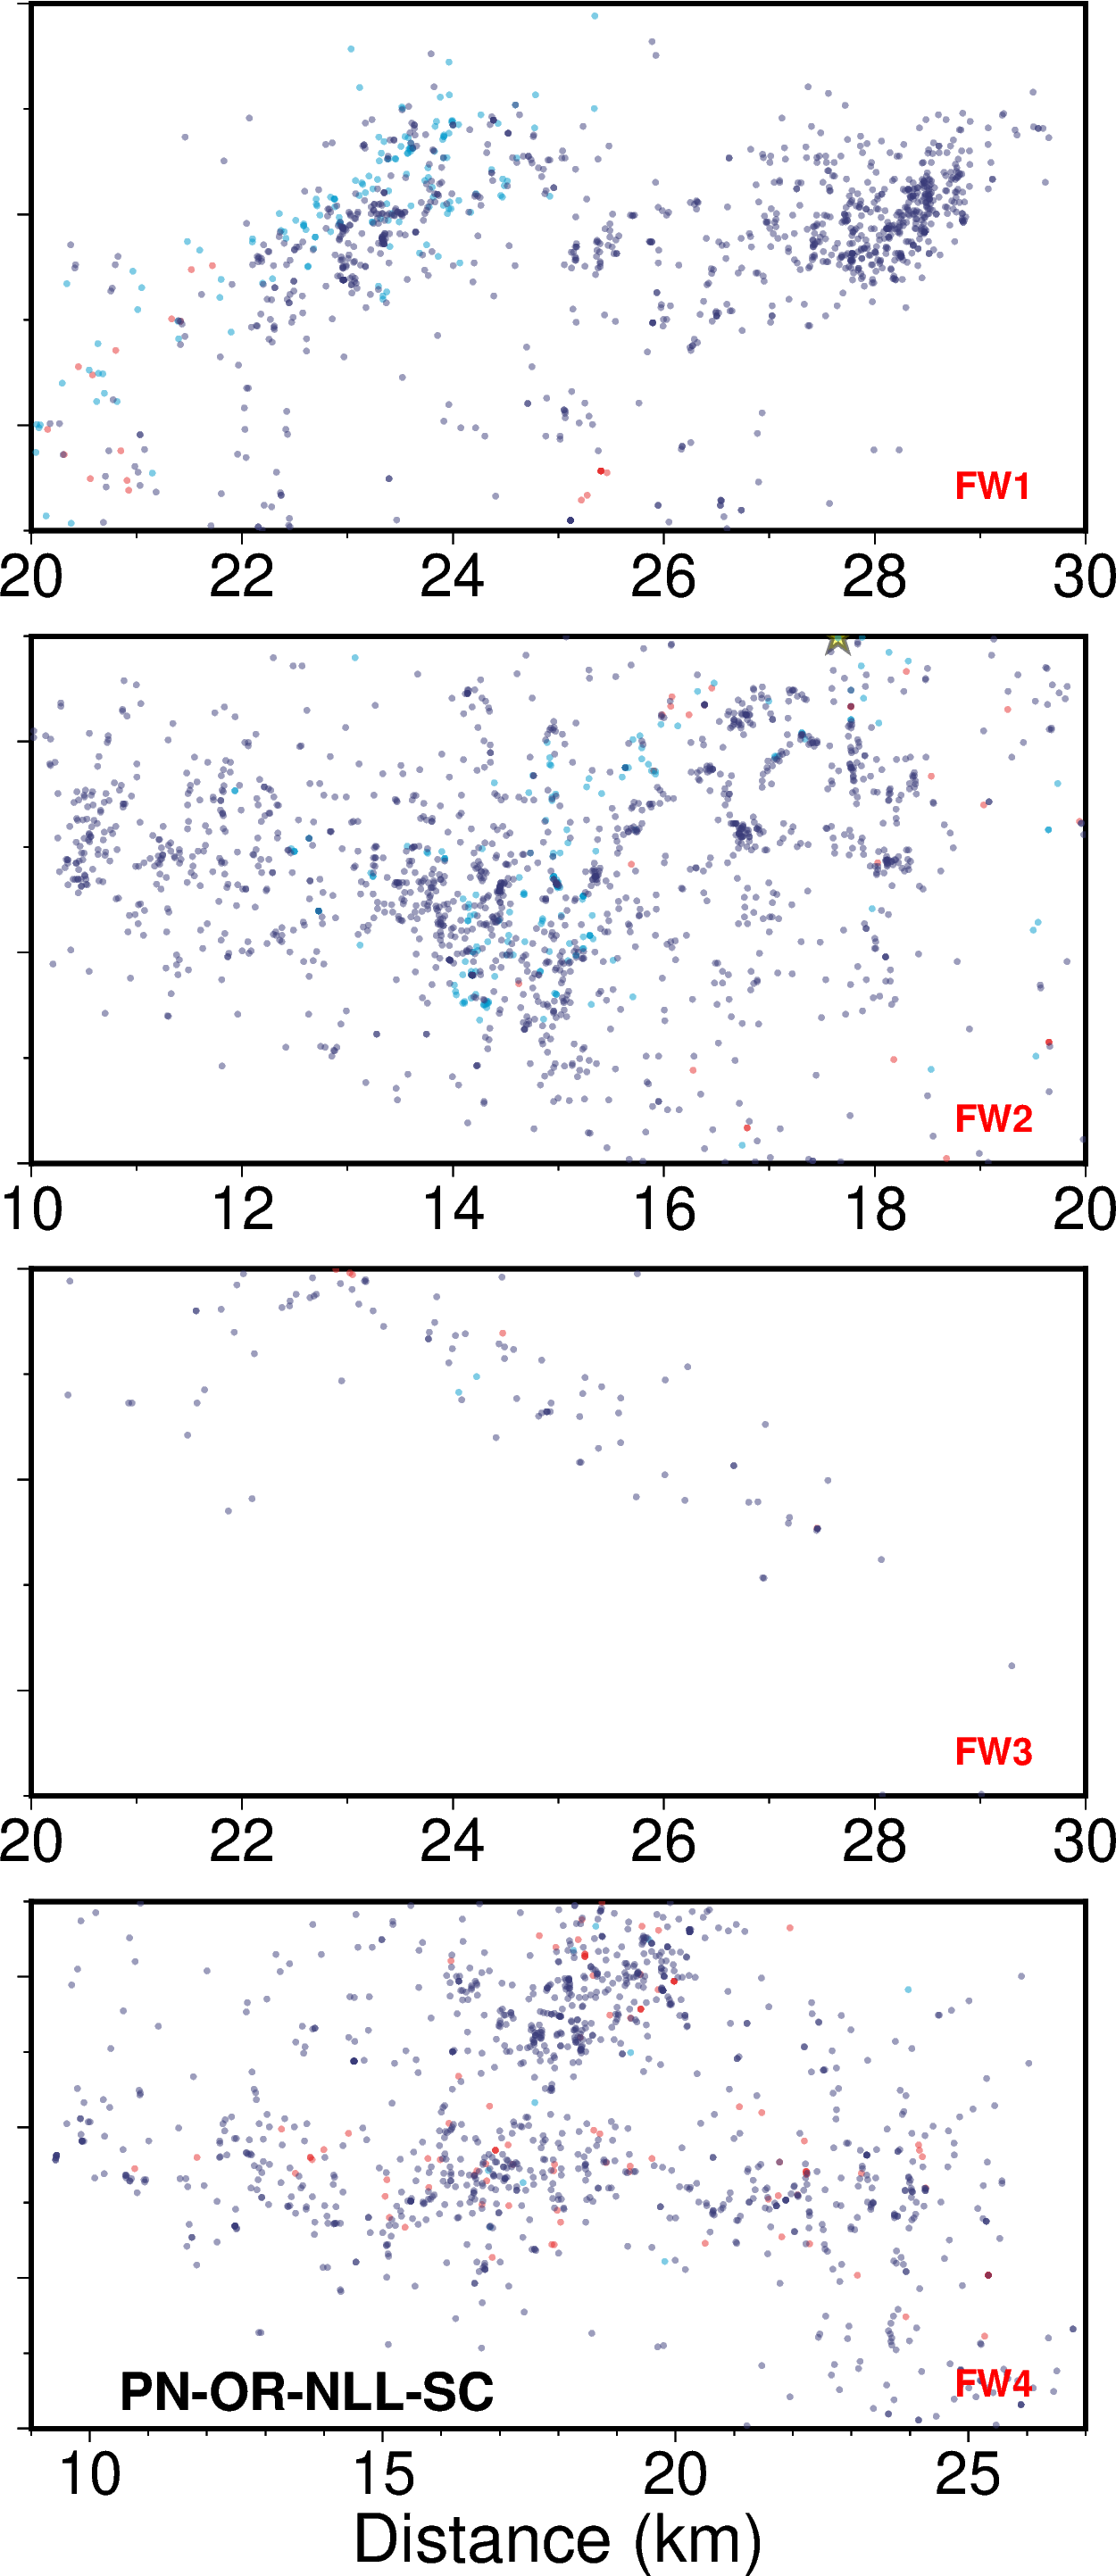

In [23]:
fig = plot_epicenter_zoom(pn_orig,"(d)","PN-OR-NLL-SC")

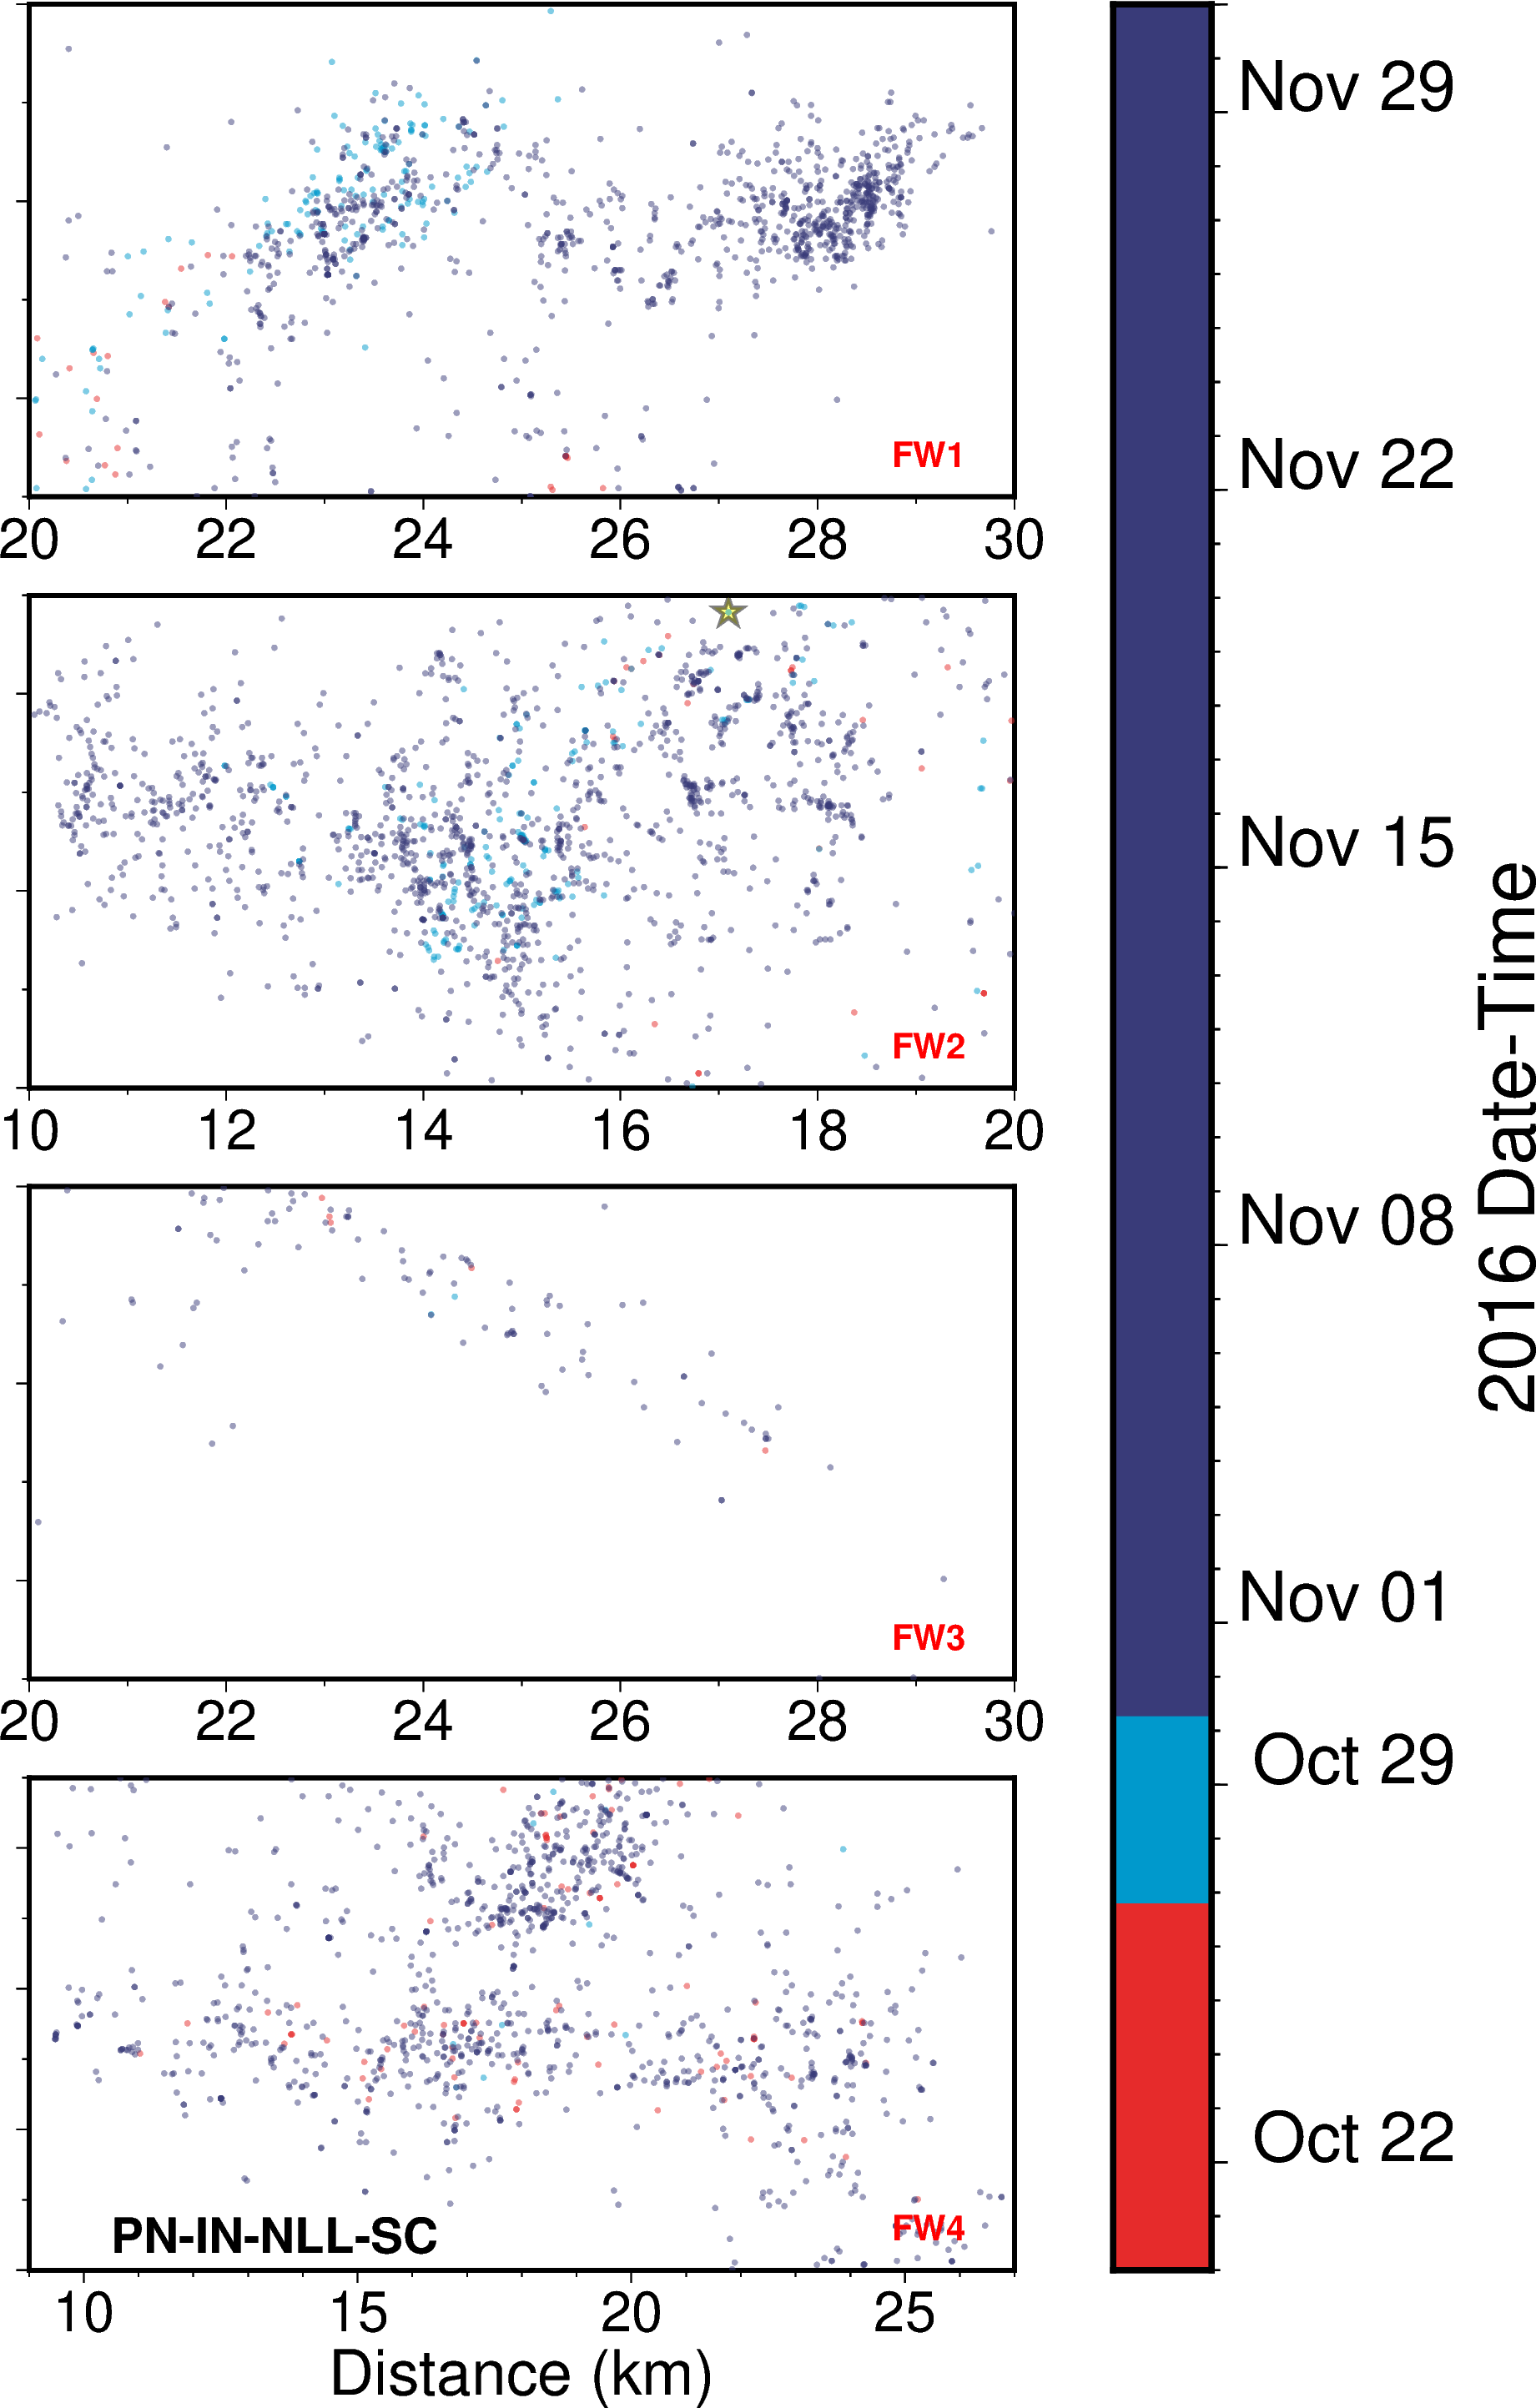

In [24]:
fig = plot_epicenter_zoom(pn_inst,"(g)","PN-IN-NLL-SC")

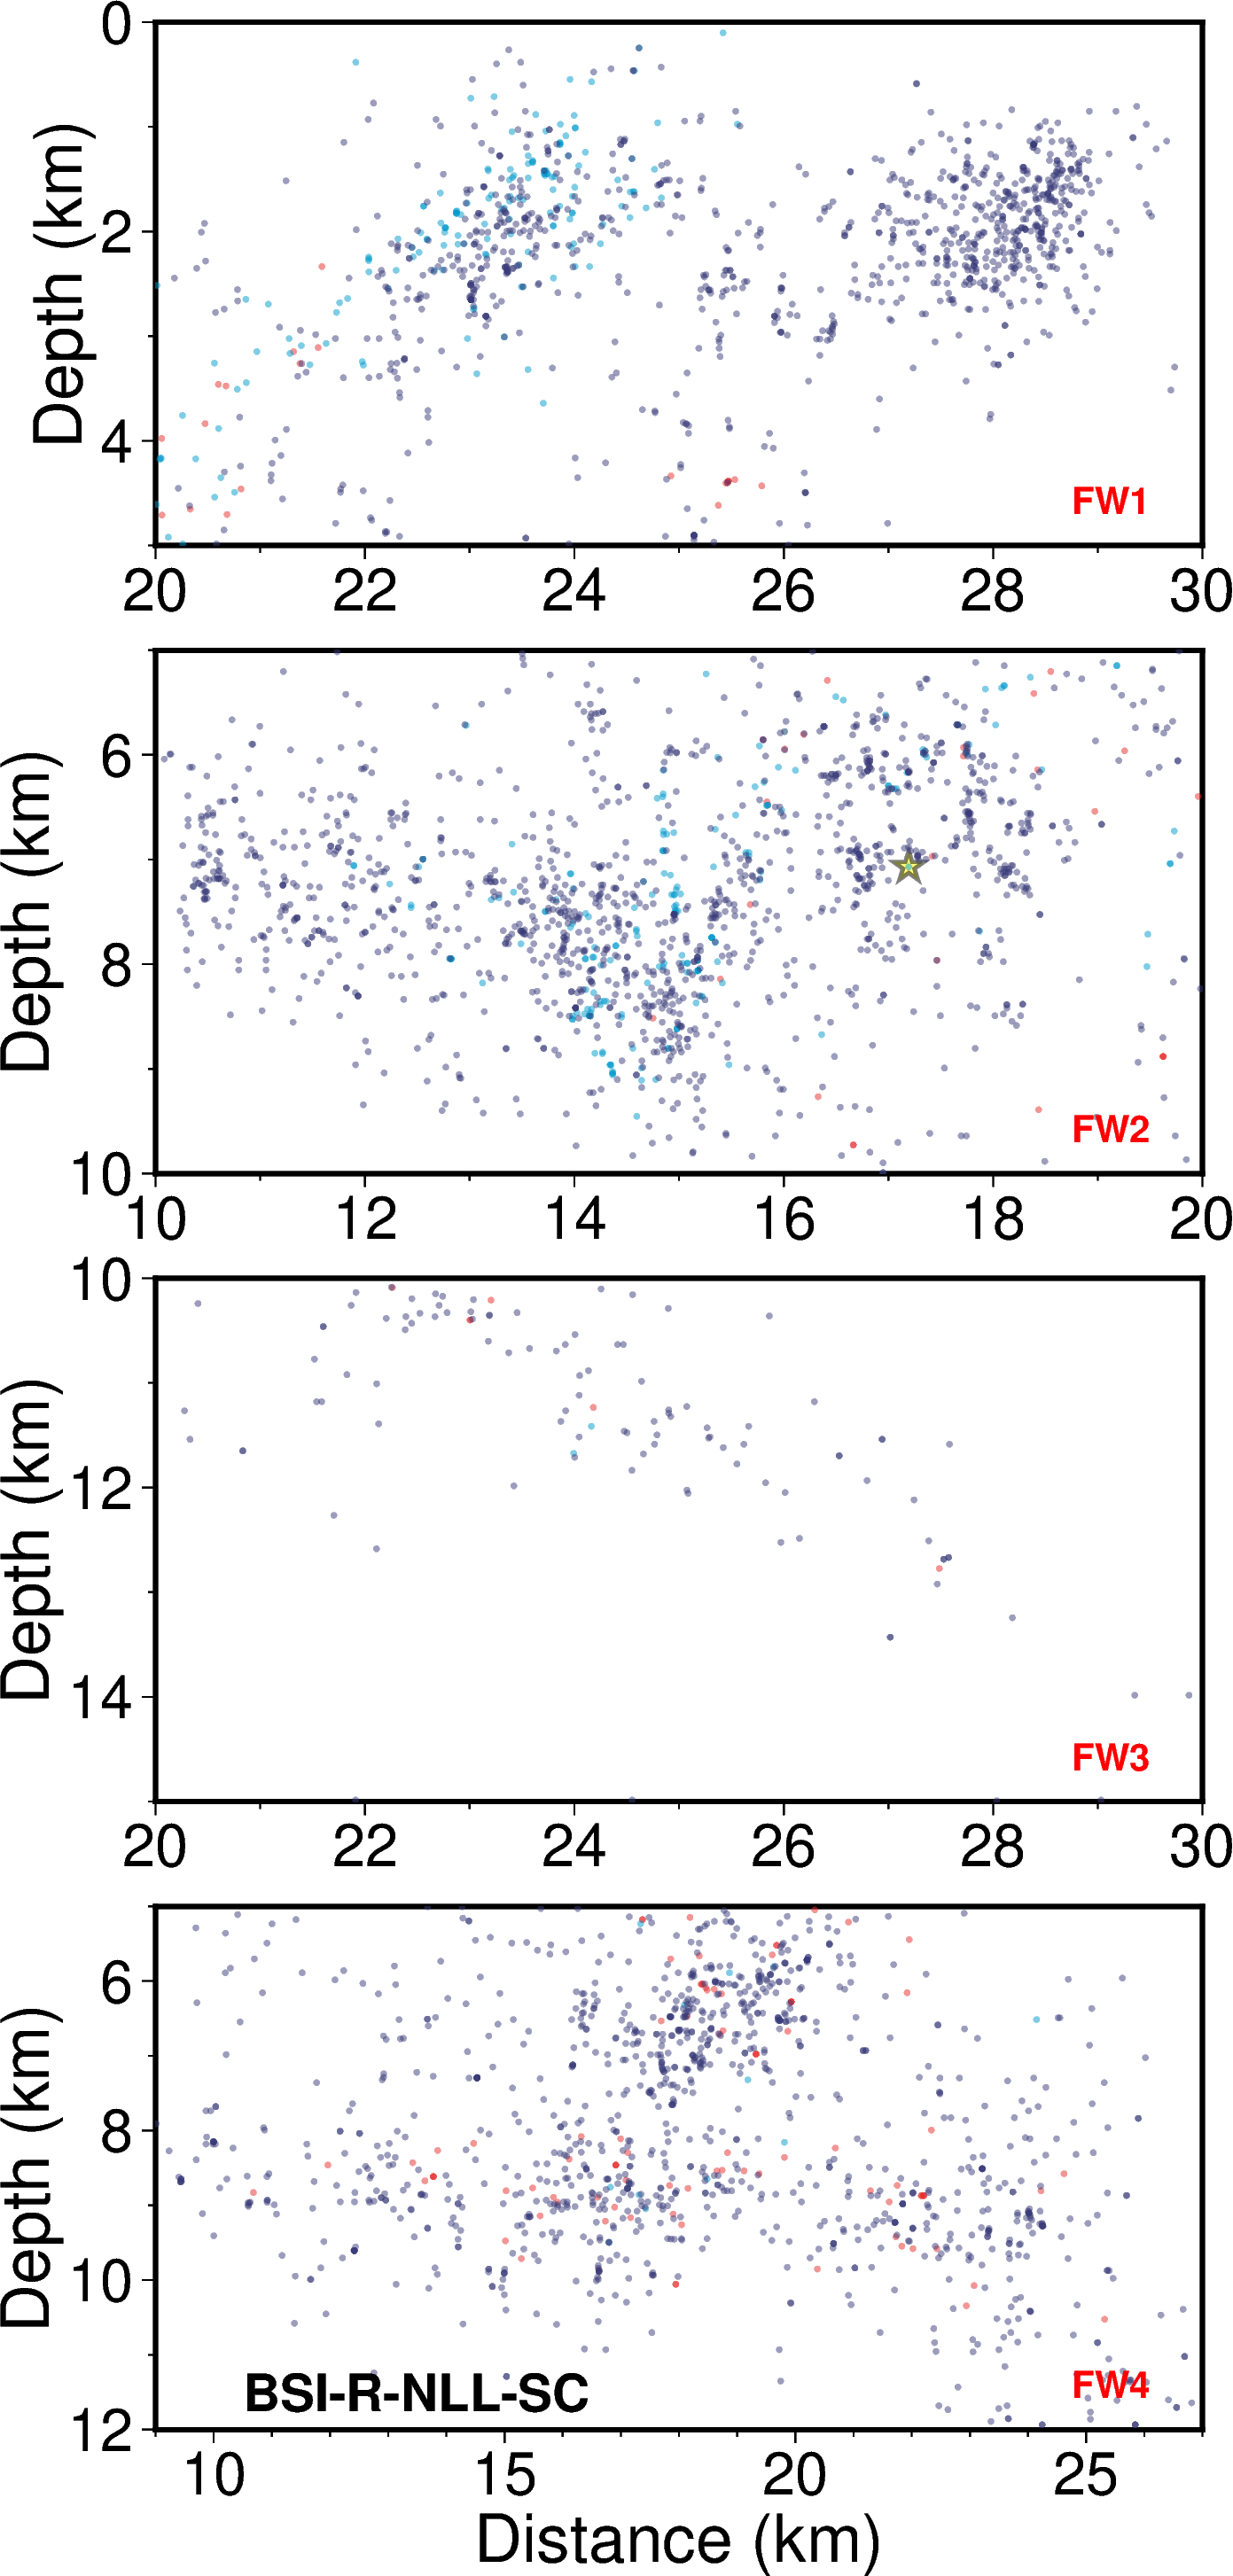

In [25]:
fig = plot_epicenter_zoom(ingv_nll,"(a)","BSI-R-NLL-SC")